This is the training of SAM with U-NET localization

In [1]:
"""

Stage 1) Train a Tiny U-Net localizer to predict a center heatmap.
Stage 2) During SAM fine-tune, use the U-Net’s peak as ONE point prompt per image,
         match that point to the GT instance (point-in-mask), and train SAM mask_decoder.

Key design choices:
- U-Net runs at u_len (e.g. 512) for speed.
- SAM still runs at 1024 with ResizeLongestSide(1024) + right/bottom pad exactly like your current dataset.
- Point coords are transformed with ResizeLongestSide.apply_coords (crucial).
- We keep your SAM training structure (freeze encoders, train mask_decoder, upsample low_res_masks).

IMPORTANT: In the SAM dataset below, we run U-Net inside __getitem__ → use DataLoader(num_workers=0)
"""

import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from pycocotools.coco import COCO
from segment_anything.utils.transforms import ResizeLongestSide
from segment_anything import sam_model_registry
from tqdm import tqdm

In [2]:
# ----------------------------
# 1) Tiny U-Net (full-res heatmap logits)
# ----------------------------

In [15]:
# ----------------------------
# 1) Tiny U-Net (full-res heatmap logits)
# ----------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_out, 3, padding=1),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(c_out, c_out, 3, padding=1),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

class TinyUNetFull(nn.Module):
    """
    Robust U-Net: handles odd H/W by interpolating decoder features
    to exactly match skip feature spatial size before concat.
    """
    def __init__(self, in_ch=3, base=16):
        super().__init__()
        b = base

        self.enc1 = ConvBlock(in_ch, b)
        self.enc2 = ConvBlock(b, 2*b)
        self.enc3 = ConvBlock(2*b, 4*b)
        self.pool = nn.MaxPool2d(2)

        self.mid  = ConvBlock(4*b, 8*b)

        # you can keep transposed convs; we’ll still align with interpolate
        self.up3  = nn.ConvTranspose2d(8*b, 4*b, 2, 2)
        self.dec3 = ConvBlock(8*b, 4*b)   # (4b + 4b) -> 4b

        self.up2  = nn.ConvTranspose2d(4*b, 2*b, 2, 2)
        self.dec2 = ConvBlock(4*b, 2*b)   # (2b + 2b) -> 2b

        self.up1  = nn.ConvTranspose2d(2*b, b, 2, 2)
        self.dec1 = ConvBlock(2*b, b)     # (b + b) -> b

        self.head = nn.Conv2d(b, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)              # [B,b,H,W]
        e2 = self.enc2(self.pool(e1))  # [B,2b,H/2,W/2]
        e3 = self.enc3(self.pool(e2))  # [B,4b,H/4,W/4]

        m  = self.mid(self.pool(e3))   # [B,8b,H/8,W/8]

        d3 = self.up3(m)               # ~[B,4b,?,?]
        # ALIGN to e3 spatial size
        if d3.shape[-2:] != e3.shape[-2:]:
            d3 = F.interpolate(d3, size=e3.shape[-2:], mode="bilinear", align_corners=False)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        # ALIGN to e2 spatial size
        if d2.shape[-2:] != e2.shape[-2:]:
            d2 = F.interpolate(d2, size=e2.shape[-2:], mode="bilinear", align_corners=False)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        # ALIGN to e1 spatial size
        if d1.shape[-2:] != e1.shape[-2:]:
            d1 = F.interpolate(d1, size=e1.shape[-2:], mode="bilinear", align_corners=False)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.head(d1)           # [B,1,H,W] logits
# U-Net tends to have odd spatial sizes + pooling/upsampling rounding cause the skip connections to misalign.
# So we always ALIGN decoder features to skip feature spatial size before concatenation.



In [4]:
# ----------------------------
# 2) Heatmap target building
# ----------------------------
def mask_centroid(binary_mask: np.ndarray):
    ys, xs = np.where(binary_mask > 0)
    if len(xs) == 0:
        return None
    return float(xs.mean()), float(ys.mean())

def gaussian_splat(H, W, cx, cy, sigma):
    y = np.arange(H, dtype=np.float32)[:, None]
    x = np.arange(W, dtype=np.float32)[None, :]
    g = np.exp(-((x - cx)**2 + (y - cy)**2) / (2 * sigma * sigma))
    return g.astype(np.float32)

def build_center_heatmap(H, W, centers, sigma=3.0):
    hm = np.zeros((H, W), dtype=np.float32)
    for (cx, cy) in centers:
        hm = np.maximum(hm, gaussian_splat(H, W, cx, cy, sigma))
    return np.clip(hm, 0.0, 1.0)

In [6]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
from segment_anything.utils.transforms import ResizeLongestSide

def gaussian_splat(H, W, cx, cy, sigma):
    y = np.arange(H, dtype=np.float32)[:, None]
    x = np.arange(W, dtype=np.float32)[None, :]
    g = np.exp(-((x - cx)**2 + (y - cy)**2) / (2 * sigma * sigma))
    return g.astype(np.float32)

def build_center_heatmap(H, W, centers, sigma=3.0):
    hm = np.zeros((H, W), dtype=np.float32)
    for (cx, cy) in centers:
        hm = np.maximum(hm, gaussian_splat(H, W, cx, cy, sigma))
    return np.clip(hm, 0.0, 1.0)

class LiveCellLocalizationDataset(Dataset):
    """
    U-Net training dataset (FAST):
      - centers from COCO bbox (no annToMask).
      - resize longest side to u_len
      - output image_u [3,Hu,Wu], heatmap [1,Hu,Wu]
    """
    def __init__(self, img_dir, ann_file, u_len=512, sigma=3.0):
        self.img_dir = img_dir
        self.coco = COCO(ann_file)
        self.image_ids = list(self.coco.imgs.keys())
        self.tu = ResizeLongestSide(u_len)
        self.u_len = u_len
        self.sigma = sigma

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        info = self.coco.imgs[image_id]
        path = os.path.join(self.img_dir, info["file_name"])

        image = np.array(Image.open(path).convert("RGB"))  # [H,W,3]
        H, W = image.shape[:2]

        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)

        # true center from the mask
        # this is way too slow and unnecessarily accurate for a U-Net target, this is just upstream for SAM
        # centers = []
        # for ann in anns:
        #     m = self.coco.annToMask(ann)        # allocates full [H,W]
        #     ys, xs = np.where(m > 0)       # scans mask pixels
        #     cx, cy = xs.mean(), ys.mean()  # centroid
        #     centers.append((cx, cy))
        
        # bbox centers in ORIGINAL coords
        centers = []
        for ann in anns:
            x, y, w, h = ann["bbox"]
            centers.append((float(x + 0.5 * w), float(y + 0.5 * h)))

        # resize image to U-net frame
        image_u = self.tu.apply_image(image)  # [Hu,Wu,3]
        Hu, Wu = image_u.shape[:2]

        # transform centers to U-frame
        if len(centers) > 0:
            coords = np.array(centers, dtype=np.float32)          # [N,2]
            coords_u = self.tu.apply_coords(coords, (H, W))       # [N,2]
            centers_u = [(float(x), float(y)) for x, y in coords_u]
        else:
            centers_u = []

        heat = build_center_heatmap(Hu, Wu, centers_u, sigma=self.sigma)

        image_t = torch.from_numpy(image_u).permute(2, 0, 1).float() / 255.0
        heat_t  = torch.from_numpy(heat).unsqueeze(0).float()

        return {"image_u": image_t, "heatmap": heat_t, "image_id": image_id}

In [7]:
# ----------------------------
# 4) Peak pick + point->GT instance match
# ----------------------------
@torch.no_grad()
def pick_global_peak(logits_1x1hw: torch.Tensor, thresh=0.2):
    """
    logits_1x1hw: [1,1,H,W] logits
    Return (x, y, score) in that heatmap frame, or None.
    """
    prob = torch.sigmoid(logits_1x1hw[0, 0])  # [H,W]
    vmax = prob.max().item()
    if vmax < thresh:
        return None
    idx = torch.argmax(prob).item()
    W = prob.shape[1]
    y = idx // W
    x = idx % W
    return float(x), float(y), float(vmax)

def match_point_to_ann(coco: COCO, anns, x_orig, y_orig):
    """
    Find GT instance whose mask contains (x_orig,y_orig). Return ann or None.
    """
    xi, yi = int(round(x_orig)), int(round(y_orig))
    for ann in anns:
        m = coco.annToMask(ann)
        H, W = m.shape
        if 0 <= yi < H and 0 <= xi < W and m[yi, xi] > 0:
            return ann
    return None



In [ ]:
# ----------------------------
# 5) SAM fine-tune dataset using ONE U-Net peak point
# ----------------------------
"""
class LiveCellSAMPseudoPointDataset(Dataset):
    """
    Returns exactly what SAM needs (point prompt instead of box prompt):

      image:        [3,1024,1024]
      mask:         [1,1024,1024]  (matched GT instance)
      point_coords: [1,1,2]        (x,y in SAM resized+pad frame)
      point_labels: [1,1]          (positive point = 1)

    U-Net runs at u_len frame inside __getitem__ → set DataLoader(num_workers=0).
    """
    def __init__(self, img_dir, ann_file, sam_model, unet_model, u_len=512, peak_thresh=0.2):
        self.img_dir = img_dir
        self.coco = COCO(ann_file)
        self.image_ids = list(self.coco.imgs.keys())

        self.tu = ResizeLongestSide(u_len)
        self.ts = ResizeLongestSide(1024)

        self.unet = unet_model.eval().to("cpu")
        self.u_len = u_len
        self.peak_thresh = peak_thresh

        # keep consistent with your current SAM dataset (you had normalization commented out)
        self.pixel_mean = sam_model.pixel_mean
        self.pixel_std = sam_model.pixel_std

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        info = self.coco.imgs[image_id]
        path = os.path.join(self.img_dir, info["file_name"])

        image = np.array(Image.open(path).convert("RGB"))  # [H,W,3]
        H, W = image.shape[:2]

        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)
        if len(anns) == 0:
            return self.__getitem__((idx + 1) % len(self.image_ids))

        # ---- U-Net frame ----
        image_u = self.tu.apply_image(image)  # [Hu,Wu,3]
        Hu, Wu = image_u.shape[:2]
        x_u = torch.from_numpy(image_u).permute(2, 0, 1).float().unsqueeze(0) / 255.0  # [1,3,Hu,Wu]

        with torch.no_grad():
            logits_u = self.unet(x_u)  # [1,1,Hu,Wu]

        peak = pick_global_peak(logits_u, thresh=self.peak_thresh)

        # ---- choose (x_orig,y_orig) + matching GT ann ----
        if peak is not None:
            x_u_peak, y_u_peak, _ = peak

            # ResizeLongestSide is uniform scale:
            scale_u = float(self.u_len) / float(max(H, W))
            x_orig = float(x_u_peak / scale_u)
            y_orig = float(y_u_peak / scale_u)

            ann = match_point_to_ann(self.coco, anns, x_orig, y_orig)
        else:
            ann = None

        # Fallback if U-Net peak is weak or lands in background:
        if ann is None:
            ann = anns[np.random.randint(len(anns))]
            m = self.coco.annToMask(ann).astype(np.uint8)
            ys, xs = np.where(m > 0)
            if len(xs) == 0:
                return self.__getitem__((idx + 1) % len(self.image_ids))
            k = np.random.randint(len(xs))
            x_orig, y_orig = float(xs[k]), float(ys[k])

        gt_mask_orig = self.coco.annToMask(ann).astype(np.uint8)  # [H,W]

        # ---- SAM resize to 1024 longest side ----
        image_s = self.ts.apply_image(image)          # [Hs,Ws,3]
        mask_s  = self.ts.apply_image(gt_mask_orig)   # [Hs,Ws]
        Hs, Ws = image_s.shape[:2]

        pt = np.array([[x_orig, y_orig]], dtype=np.float32)  # [1,2] original coords
        pt_s = self.ts.apply_coords(pt, (H, W)).astype(np.float32)  # [1,2] resized coords

        # ---- pad right/bottom to 1024x1024 (coords unchanged) ----
        pad_h = 1024 - Hs
        pad_w = 1024 - Ws

        image_t = torch.from_numpy(image_s).permute(2, 0, 1).float() / 255.0  # [3,Hs,Ws]
        mask_t  = torch.from_numpy(mask_s).unsqueeze(0).float()               # [1,Hs,Ws]

        image_t = F.pad(image_t, (0, pad_w, 0, pad_h))  # [3,1024,1024]
        mask_t  = F.pad(mask_t,  (0, pad_w, 0, pad_h))  # [1,1024,1024]

        point_coords = torch.from_numpy(pt_s).float().unsqueeze(0)            # [1,1,2]
        point_labels = torch.ones((1, 1), dtype=torch.int64)                  # [1,1]

        return {
            "image": image_t,
            "mask": mask_t,
            "point_coords": point_coords,
            "point_labels": point_labels,
            "image_id": image_id,
        }

"""

In [20]:
# ----------------------------
# 5) SAM fine-tune dataset using ONE U-Net peak point
# ----------------------------
class LiveCellSAMPseudoPointDataset(Dataset):
    """
    Returns exactly what SAM needs (point prompt instead of box prompt):

      image:        [3,1024,1024]
      mask:         [1,1024,1024]  (matched GT instance)
      point_coords: [1,1,2]        (x,y in SAM resized+pad frame)
      point_labels: [1,1]          (positive point = 1)

    U-Net runs at u_len frame inside __getitem__ → set DataLoader(num_workers=0).
    """
    def __init__(self, img_dir, ann_file, sam_model, unet_model, u_len=512, peak_thresh=0.2):
        self.img_dir = img_dir
        self.coco = COCO(ann_file)
        self.image_ids = list(self.coco.imgs.keys())

        self.tu = ResizeLongestSide(u_len)
        self.ts = ResizeLongestSide(1024)

        self.unet = unet_model.eval().to("cpu")
        self.u_len = u_len
        self.peak_thresh = peak_thresh

        # keep consistent with your current SAM dataset (you had normalization commented out)
        self.pixel_mean = sam_model.pixel_mean
        self.pixel_std = sam_model.pixel_std

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        info = self.coco.imgs[image_id]
        path = os.path.join(self.img_dir, info["file_name"])

        image = np.array(Image.open(path).convert("RGB"))  # [H,W,3]
        H, W = image.shape[:2]

        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)
        if len(anns) == 0:
            return self.__getitem__((idx + 1) % len(self.image_ids))

        # ---- U-Net frame ----
        image_u = self.tu.apply_image(image)  # [Hu,Wu,3]
        Hu, Wu = image_u.shape[:2]
        x_u = torch.from_numpy(image_u).permute(2, 0, 1).float().unsqueeze(0) / 255.0  # [1,3,Hu,Wu]

        with torch.no_grad():
            logits_u = self.unet(x_u)  # [1,1,Hu,Wu]

        peak = pick_global_peak(logits_u, thresh=self.peak_thresh)

        # ---- choose (x_orig,y_orig) + matching GT ann ----
        if peak is not None:
            x_u_peak, y_u_peak, _ = peak

            # ResizeLongestSide is uniform scale:
            scale_u = float(self.u_len) / float(max(H, W))
            x_orig = float(x_u_peak / scale_u)
            y_orig = float(y_u_peak / scale_u)

            ann = match_point_to_ann(self.coco, anns, x_orig, y_orig)
        else:
            ann = None

        # Fallback if U-Net peak is weak or lands in background:
        if ann is None:
            ann = anns[np.random.randint(len(anns))]
            m = self.coco.annToMask(ann).astype(np.uint8)
            ys, xs = np.where(m > 0)
            if len(xs) == 0:
                return self.__getitem__((idx + 1) % len(self.image_ids))
            k = np.random.randint(len(xs))
            x_orig, y_orig = float(xs[k]), float(ys[k])

        gt_mask_orig = self.coco.annToMask(ann).astype(np.uint8)  # [H,W]

        # ---- SAM resize to 1024 longest side ----
        image_s = self.ts.apply_image(image)          # [Hs,Ws,3]
        mask_s  = self.ts.apply_image(gt_mask_orig)   # [Hs,Ws]
        Hs, Ws = image_s.shape[:2]

        pt = np.array([[x_orig, y_orig]], dtype=np.float32)  # [1,2] original coords
        pt_s = self.ts.apply_coords(pt, (H, W)).astype(np.float32)  # [1,2] resized coords

        # ---- pad right/bottom to 1024x1024 (coords unchanged) ----
        pad_h = 1024 - Hs
        pad_w = 1024 - Ws

        image_t = torch.from_numpy(image_s).permute(2, 0, 1).float() / 255.0  # [3,Hs,Ws]
        mask_t  = torch.from_numpy(mask_s).unsqueeze(0).float()               # [1,Hs,Ws]

        image_t = F.pad(image_t, (0, pad_w, 0, pad_h))  # [3,1024,1024]
        mask_t  = F.pad(mask_t,  (0, pad_w, 0, pad_h))  # [1,1024,1024]

        point_coords = torch.from_numpy(pt_s).float()               # pt_s is [1,2] -> tensor [1,2]
        point_labels = torch.ones((1,), dtype=torch.int64)          # [1]
        
        return {
            "image": image_t,
            "mask": mask_t,
            "point_coords": point_coords,
            "point_labels": point_labels,
            "image_id": image_id,
        }

In [9]:
# ----------------------------
# 6) Train U-Net localizer
# ----------------------------
def train_unet_localizer(img_dir, ann_file, u_len=512, sigma=3.0, epochs=5, batch_size=4, lr=1e-3, device="cuda"):
    ds = LiveCellLocalizationDataset(img_dir, ann_file, u_len=u_len, sigma=sigma)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

    unet = TinyUNetFull(in_ch=3, base=16).to(device)
    opt = torch.optim.AdamW(unet.parameters(), lr=lr, weight_decay=1e-4)
    crit = nn.BCEWithLogitsLoss()

    unet.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        for batch in tqdm(dl, desc=f"[U-Net] epoch {ep}/{epochs}"):
            x = batch["image_u"].to(device)     # [B,3,Hu,Wu]
            y = batch["heatmap"].to(device)     # [B,1,Hu,Wu]
            logits = unet(x)                    # [B,1,Hu,Wu]
            loss = crit(logits, y)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            total += loss.item()

        print(f"[U-Net] epoch {ep} avg_loss={total/len(dl):.4f}")

    return unet


# ----------------------------
# 7) Example IoU loss (if you don't already have one)
#    If you already defined iou_loss, keep yours.
# ----------------------------
def iou_loss(pred_logits, gt_mask, eps=1e-6):
    """
    pred_logits: [B,1,H,W] logits
    gt_mask:     [B,1,H,W] float {0,1}
    """
    pred = torch.sigmoid(pred_logits)
    inter = (pred * gt_mask).sum(dim=(2, 3))
    union = (pred + gt_mask - pred * gt_mask).sum(dim=(2, 3))
    iou = (inter + eps) / (union + eps)
    return (1.0 - iou).mean()



In [21]:
# ----------------------------
# 8) SAM fine-tune with ONE point prompt (U-Net peak)
# ----------------------------
def finetune_sam_with_unet_point(
    sam,
    img_dir,
    ann_file,
    unet_model,
    steps=2000,
    lr=1e-5,
    u_len=512,
    peak_thresh=0.2,
    device="cuda",
):
    dataset = LiveCellSAMPseudoPointDataset(
        img_dir=img_dir,
        ann_file=ann_file,
        sam_model=sam,
        unet_model=unet_model,
        u_len=u_len,
        peak_thresh=peak_thresh,
    )

    # U-Net is called inside __getitem__ -> keep num_workers=0
    loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

    # freeze everything except mask decoder (same as your code)
    for p in sam.image_encoder.parameters():
        p.requires_grad = False
    for p in sam.prompt_encoder.parameters():
        p.requires_grad = False
    for p in sam.mask_decoder.parameters():
        p.requires_grad = True

    optimizer = torch.optim.AdamW(sam.mask_decoder.parameters(), lr=lr)

    sam.train()
    sam.to(device)

    pbar = tqdm(enumerate(loader), total=steps, desc="[SAM] fine-tune")
    for step, batch in pbar:
        if step >= steps:
            break

        img = batch["image"].to(device)          # [B,3,1024,1024]
        gt_mask = batch["mask"].to(device)       # [B,1,1024,1024]
        pxy = batch["point_coords"].to(device)   # [B,1,2]
        plab = batch["point_labels"].to(device)  # [B,1]
        print("pxy", pxy.shape, "plab", plab.shape)
        
        # same structure as your loop
        with torch.no_grad():
            image_embedding = sam.image_encoder(img)

        sparse, dense = sam.prompt_encoder(
            points=(pxy, plab),
            boxes=None,
            masks=None
        )

        low_res_masks, _ = sam.mask_decoder(
            image_embedding,
            image_pe=sam.prompt_encoder.get_dense_pe().to(device),
            sparse_prompt_embeddings=sparse,
            dense_prompt_embeddings=dense,
            multimask_output=False
        )

        pred_mask = F.interpolate(
            low_res_masks,
            size=(1024, 1024),
            mode="bilinear",
            align_corners=False
        )

        loss = iou_loss(pred_mask, gt_mask)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

        if step % 100 == 0:
            pbar.set_postfix(loss=float(loss.item()))
            print(f"[SAM] step {step} loss={loss.item():.4f}")

    return sam


In [11]:
import os, json, time
import torch

def save_sam_registry(
    sam,
    optimizer,
    save_root="model_registry",
    model_name="livecell_sam_vit_b_boxprompt",
    metrics=None,
    config=None
):
    """
    Saves a registry-style artifact:
      model_registry/<model_name>/<version>/
        - mask_decoder.pt
        - optimizer.pt
        - metadata.json
    """
    os.makedirs(save_root, exist_ok=True)

    version = time.strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(save_root, model_name, version)
    os.makedirs(run_dir, exist_ok=True)

    # core weights (decoder-only fine-tune)
    torch.save(sam.mask_decoder.state_dict(), os.path.join(run_dir, "mask_decoder.pt"))

    # optional optimizer state
    if optimizer is not None:
        torch.save(optimizer.state_dict(), os.path.join(run_dir, "optimizer.pt"))

    metadata = {
        "model_name": model_name,
        "version": version,
        "created_at": version,
        "metrics": metrics or {},
        "config": config or {},
        "notes": "SAM fine-tune: trained mask_decoder only; encoders frozen.",
    }

    with open(os.path.join(run_dir, "metadata.json"), "w") as f:
        json.dump(metadata, f, indent=2)

    print("Saved to:", run_dir)
    return run_dir

In [ ]:
# it turned out that this U-NET training is incredibly slow, root cause is:
# COCO annToMask is slow
# ----------------------------
# solution to speed up:
# 1) use bbox centers instead of mask centroids for U-NET target
# 2) use DataLoader(num_workers=0) since U-NET is called inside __getitem__
# 3) batch size = 1

In [12]:
IMG_DIR  = "data/livecell/images/train"
ANN_FILE = "data/livecell/annotations/train.json"
ds = LiveCellLocalizationDataset(IMG_DIR, ANN_FILE, u_len=512, sigma=3.0)

import time
t0 = time.time()
_ = ds[0]
print("one sample seconds:", time.time() - t0)

loading annotations into memory...
Done (t=5.72s)
creating index...
index created!
one sample seconds: 0.20691990852355957


In [13]:
# load one sample to test speed, it is about 0.2s per sample now

In [16]:
# ----------------------------
# 9) Main runnable example (matches your SAM loading)
# ----------------------------

device = "cuda"

# --- your SAM load ---
sam = sam_model_registry["vit_b"](checkpoint="sam/sam_vit_b_01ec64.pth").to(device)

# --- paths ---
IMG_DIR  = "data/livecell/images/train"
ANN_FILE = "data/livecell/annotations/train.json"

# --- stage 1: train U-Net localizer ---
unet = train_unet_localizer(
    img_dir=IMG_DIR,
    ann_file=ANN_FILE,
    u_len=512,
    sigma=3.0,
    epochs=1,
    batch_size=1,
    lr=1e-3,
    device=device,
)

loading annotations into memory...
Done (t=5.74s)
creating index...
index created!


[U-Net] epoch 1/1: 100%|██████████| 3253/3253 [05:00<00:00, 10.83it/s]


[U-Net] epoch 1 avg_loss=0.1945


In [17]:
# save artifacts
torch.save(unet.state_dict(), "localization/unet_localizer.pt")

In [22]:
# --- stage 2: fine-tune SAM with U-Net peak point prompts ---
sam = finetune_sam_with_unet_point(
    sam=sam,
    img_dir=IMG_DIR,
    ann_file=ANN_FILE,
    unet_model=unet,
    steps=2000,        # adjust; you said your fine-tune is fast (~5 min)
    lr=1e-5,
    u_len=512,
    peak_thresh=0.2,
    device=device,
)

loading annotations into memory...
Done (t=5.77s)
creating index...
index created!


[SAM] fine-tune:   0%|          | 0/2000 [00:00<?, ?it/s]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   0%|          | 2/2000 [00:00<08:09,  4.08it/s, loss=0.358]

[SAM] step 0 loss=0.3578
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   0%|          | 4/2000 [00:00<05:42,  5.82it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   0%|          | 6/2000 [00:01<04:56,  6.73it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   0%|          | 8/2000 [00:01<04:09,  7.99it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   0%|          | 9/2000 [00:01<04:05,  8.12it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   1%|          | 12/2000 [00:01<03:51,  8.59it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   1%|          | 13/2000 [00:01<03:46,  8.78it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   1%|          | 16/2000 [00:02<04:05,  8.09it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   1%|          | 17/2000 [00:02<04:03,  8.15it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   1%|          | 20/2000 [00:02<04:10,  7.89it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   1%|          | 22/2000 [00:02<03:50,  8.58it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   1%|▏         | 25/2000 [00:03<03:43,  8.85it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   1%|▏         | 26/2000 [00:03<03:45,  8.74it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   1%|▏         | 29/2000 [00:03<03:49,  8.60it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   2%|▏         | 31/2000 [00:04<03:48,  8.63it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   2%|▏         | 32/2000 [00:04<03:52,  8.47it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   2%|▏         | 34/2000 [00:04<04:09,  7.87it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   2%|▏         | 37/2000 [00:04<04:39,  7.03it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   2%|▏         | 39/2000 [00:05<04:04,  8.01it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   2%|▏         | 41/2000 [00:05<03:42,  8.82it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   2%|▏         | 43/2000 [00:05<03:41,  8.83it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   2%|▏         | 45/2000 [00:05<03:37,  8.99it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   2%|▏         | 47/2000 [00:05<03:35,  9.04it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   2%|▏         | 49/2000 [00:06<03:34,  9.09it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   2%|▎         | 50/2000 [00:06<03:37,  8.95it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   3%|▎         | 53/2000 [00:06<03:35,  9.06it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   3%|▎         | 55/2000 [00:06<03:29,  9.30it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   3%|▎         | 57/2000 [00:07<03:38,  8.90it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   3%|▎         | 59/2000 [00:07<03:49,  8.47it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   3%|▎         | 60/2000 [00:07<04:34,  7.07it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   3%|▎         | 63/2000 [00:07<03:52,  8.31it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   3%|▎         | 65/2000 [00:08<03:55,  8.21it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   3%|▎         | 66/2000 [00:08<05:00,  6.43it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   3%|▎         | 68/2000 [00:08<04:25,  7.28it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   4%|▎         | 70/2000 [00:08<04:09,  7.72it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   4%|▎         | 72/2000 [00:09<04:02,  7.95it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   4%|▎         | 74/2000 [00:09<03:59,  8.05it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   4%|▍         | 77/2000 [00:09<03:45,  8.54it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   4%|▍         | 79/2000 [00:09<03:41,  8.68it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   4%|▍         | 80/2000 [00:10<03:40,  8.70it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   4%|▍         | 83/2000 [00:10<03:53,  8.23it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   4%|▍         | 85/2000 [00:10<03:42,  8.59it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   4%|▍         | 87/2000 [00:10<03:43,  8.55it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   4%|▍         | 89/2000 [00:11<03:40,  8.65it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   5%|▍         | 91/2000 [00:11<03:35,  8.85it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   5%|▍         | 93/2000 [00:11<03:34,  8.89it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   5%|▍         | 95/2000 [00:11<03:34,  8.90it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   5%|▍         | 97/2000 [00:11<03:27,  9.16it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   5%|▍         | 98/2000 [00:12<03:37,  8.76it/s, loss=0.358]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   5%|▌         | 101/2000 [00:12<03:50,  8.24it/s, loss=0.11] 

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
[SAM] step 100 loss=0.1097


[SAM] fine-tune:   5%|▌         | 103/2000 [00:12<03:36,  8.76it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   5%|▌         | 104/2000 [00:12<03:35,  8.78it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   5%|▌         | 107/2000 [00:13<03:36,  8.72it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   5%|▌         | 109/2000 [00:13<03:30,  8.99it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   6%|▌         | 111/2000 [00:13<03:37,  8.67it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   6%|▌         | 112/2000 [00:13<03:34,  8.79it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   6%|▌         | 115/2000 [00:14<03:39,  8.58it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   6%|▌         | 117/2000 [00:14<03:37,  8.66it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   6%|▌         | 119/2000 [00:14<03:36,  8.70it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   6%|▌         | 120/2000 [00:14<03:34,  8.78it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   6%|▌         | 122/2000 [00:14<03:51,  8.10it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   6%|▋         | 125/2000 [00:15<03:39,  8.54it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   6%|▋         | 127/2000 [00:15<03:37,  8.62it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   6%|▋         | 129/2000 [00:15<03:35,  8.69it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   6%|▋         | 130/2000 [00:15<03:45,  8.31it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   7%|▋         | 133/2000 [00:16<03:43,  8.34it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   7%|▋         | 134/2000 [00:16<03:38,  8.54it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   7%|▋         | 137/2000 [00:16<03:40,  8.45it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   7%|▋         | 138/2000 [00:16<03:39,  8.49it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   7%|▋         | 141/2000 [00:17<03:38,  8.50it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   7%|▋         | 142/2000 [00:17<03:37,  8.54it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   7%|▋         | 144/2000 [00:17<04:01,  7.68it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   7%|▋         | 147/2000 [00:17<03:42,  8.33it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   7%|▋         | 149/2000 [00:18<03:41,  8.37it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   8%|▊         | 151/2000 [00:18<03:31,  8.76it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   8%|▊         | 153/2000 [00:18<03:37,  8.49it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   8%|▊         | 155/2000 [00:19<04:20,  7.10it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   8%|▊         | 157/2000 [00:19<03:55,  7.83it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   8%|▊         | 158/2000 [00:19<03:43,  8.23it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   8%|▊         | 161/2000 [00:19<03:46,  8.13it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   8%|▊         | 163/2000 [00:19<03:41,  8.30it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   8%|▊         | 164/2000 [00:20<03:39,  8.35it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   8%|▊         | 166/2000 [00:20<04:04,  7.50it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   8%|▊         | 168/2000 [00:20<03:57,  7.70it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   9%|▊         | 171/2000 [00:21<03:37,  8.41it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   9%|▊         | 173/2000 [00:21<03:47,  8.05it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   9%|▉         | 175/2000 [00:21<03:34,  8.50it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   9%|▉         | 177/2000 [00:21<03:25,  8.88it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   9%|▉         | 179/2000 [00:21<03:49,  7.95it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   9%|▉         | 182/2000 [00:22<03:52,  7.81it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   9%|▉         | 183/2000 [00:22<03:52,  7.81it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   9%|▉         | 185/2000 [00:22<03:38,  8.29it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   9%|▉         | 187/2000 [00:22<03:32,  8.53it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:   9%|▉         | 189/2000 [00:23<03:33,  8.50it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  10%|▉         | 192/2000 [00:23<03:40,  8.18it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  10%|▉         | 194/2000 [00:23<03:26,  8.76it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  10%|▉         | 195/2000 [00:23<03:28,  8.64it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  10%|▉         | 197/2000 [00:24<03:35,  8.36it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  10%|█         | 200/2000 [00:24<03:41,  8.13it/s, loss=0.11]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  10%|█         | 202/2000 [00:24<03:58,  7.55it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
[SAM] step 200 loss=0.1216
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  10%|█         | 203/2000 [00:24<03:51,  7.75it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  10%|█         | 206/2000 [00:25<03:45,  7.95it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  10%|█         | 208/2000 [00:25<03:29,  8.55it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  10%|█         | 209/2000 [00:25<03:27,  8.64it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  11%|█         | 211/2000 [00:25<03:25,  8.71it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  11%|█         | 214/2000 [00:26<03:32,  8.40it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  11%|█         | 215/2000 [00:26<03:36,  8.25it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  11%|█         | 218/2000 [00:26<03:30,  8.45it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  11%|█         | 220/2000 [00:26<03:22,  8.77it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  11%|█         | 222/2000 [00:27<03:35,  8.25it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  11%|█         | 224/2000 [00:27<03:35,  8.22it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  11%|█▏        | 226/2000 [00:27<03:27,  8.57it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  11%|█▏        | 228/2000 [00:27<03:37,  8.16it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  12%|█▏        | 230/2000 [00:28<03:25,  8.63it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  12%|█▏        | 232/2000 [00:28<03:23,  8.71it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  12%|█▏        | 233/2000 [00:28<03:27,  8.50it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  12%|█▏        | 236/2000 [00:28<03:28,  8.48it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  12%|█▏        | 237/2000 [00:29<03:24,  8.60it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  12%|█▏        | 240/2000 [00:29<03:24,  8.62it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  12%|█▏        | 241/2000 [00:29<03:21,  8.72it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  12%|█▏        | 244/2000 [00:29<03:24,  8.59it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  12%|█▏        | 246/2000 [00:30<03:21,  8.70it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  12%|█▏        | 247/2000 [00:30<03:21,  8.71it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  12%|█▏        | 249/2000 [00:30<03:17,  8.85it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  13%|█▎        | 252/2000 [00:30<03:26,  8.48it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  13%|█▎        | 254/2000 [00:30<03:22,  8.62it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  13%|█▎        | 256/2000 [00:31<03:23,  8.57it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  13%|█▎        | 257/2000 [00:31<03:34,  8.14it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  13%|█▎        | 259/2000 [00:31<03:31,  8.22it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  13%|█▎        | 262/2000 [00:32<03:39,  7.93it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  13%|█▎        | 263/2000 [00:32<03:34,  8.09it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  13%|█▎        | 266/2000 [00:32<03:31,  8.19it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  13%|█▎        | 267/2000 [00:32<03:25,  8.42it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  14%|█▎        | 270/2000 [00:32<03:31,  8.18it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  14%|█▎        | 272/2000 [00:33<03:28,  8.27it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  14%|█▎        | 273/2000 [00:33<03:27,  8.32it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  14%|█▍        | 276/2000 [00:33<03:31,  8.15it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  14%|█▍        | 277/2000 [00:33<03:24,  8.43it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  14%|█▍        | 280/2000 [00:34<03:44,  7.66it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  14%|█▍        | 281/2000 [00:34<03:36,  7.95it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  14%|█▍        | 284/2000 [00:34<03:26,  8.31it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  14%|█▍        | 286/2000 [00:34<03:24,  8.38it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  14%|█▍        | 287/2000 [00:35<03:23,  8.41it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  14%|█▍        | 290/2000 [00:35<03:20,  8.51it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  15%|█▍        | 292/2000 [00:35<03:18,  8.60it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  15%|█▍        | 293/2000 [00:35<03:29,  8.16it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  15%|█▍        | 295/2000 [00:36<03:34,  7.94it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  15%|█▍        | 298/2000 [00:36<03:21,  8.46it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  15%|█▍        | 299/2000 [00:36<03:33,  7.95it/s, loss=0.122]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  15%|█▌        | 302/2000 [00:36<03:23,  8.34it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
[SAM] step 300 loss=0.0692
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  15%|█▌        | 304/2000 [00:37<03:25,  8.23it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  15%|█▌        | 306/2000 [00:37<03:24,  8.28it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  15%|█▌        | 308/2000 [00:37<03:22,  8.35it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  15%|█▌        | 309/2000 [00:37<03:17,  8.55it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  16%|█▌        | 311/2000 [00:38<03:30,  8.02it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  16%|█▌        | 314/2000 [00:38<03:21,  8.35it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  16%|█▌        | 315/2000 [00:38<03:18,  8.50it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  16%|█▌        | 317/2000 [00:38<03:19,  8.43it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  16%|█▌        | 319/2000 [00:38<03:15,  8.60it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  16%|█▌        | 321/2000 [00:39<03:18,  8.44it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  16%|█▌        | 323/2000 [00:39<03:33,  7.86it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  16%|█▋        | 325/2000 [00:39<03:34,  7.81it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  16%|█▋        | 327/2000 [00:39<03:27,  8.06it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  16%|█▋        | 330/2000 [00:40<03:19,  8.38it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  17%|█▋        | 331/2000 [00:40<03:15,  8.52it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  17%|█▋        | 334/2000 [00:40<03:08,  8.82it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  17%|█▋        | 335/2000 [00:40<03:21,  8.27it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  17%|█▋        | 338/2000 [00:41<03:17,  8.41it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  17%|█▋        | 339/2000 [00:41<03:11,  8.68it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  17%|█▋        | 342/2000 [00:41<03:19,  8.32it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  17%|█▋        | 343/2000 [00:41<03:14,  8.53it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  17%|█▋        | 345/2000 [00:42<03:19,  8.30it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  17%|█▋        | 347/2000 [00:42<03:20,  8.25it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  17%|█▋        | 349/2000 [00:42<03:17,  8.35it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  18%|█▊        | 351/2000 [00:42<03:24,  8.08it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  18%|█▊        | 353/2000 [00:43<03:14,  8.48it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  18%|█▊        | 355/2000 [00:43<04:53,  5.61it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  18%|█▊        | 358/2000 [00:43<03:44,  7.32it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  18%|█▊        | 360/2000 [00:44<03:26,  7.95it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  18%|█▊        | 361/2000 [00:44<03:21,  8.12it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  18%|█▊        | 363/2000 [00:44<03:23,  8.04it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  18%|█▊        | 365/2000 [00:44<03:31,  7.75it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  18%|█▊        | 367/2000 [00:44<03:23,  8.02it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  18%|█▊        | 369/2000 [00:45<03:24,  7.96it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  19%|█▊        | 372/2000 [00:45<03:16,  8.30it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  19%|█▊        | 374/2000 [00:45<03:43,  7.28it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  19%|█▉        | 375/2000 [00:46<03:36,  7.52it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  19%|█▉        | 378/2000 [00:46<03:26,  7.86it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  19%|█▉        | 379/2000 [00:46<03:17,  8.19it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  19%|█▉        | 382/2000 [00:46<03:19,  8.12it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  19%|█▉        | 383/2000 [00:47<03:20,  8.08it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  19%|█▉        | 385/2000 [00:47<03:49,  7.05it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  19%|█▉        | 386/2000 [00:47<03:33,  7.56it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  19%|█▉        | 389/2000 [00:47<03:28,  7.73it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  20%|█▉        | 391/2000 [00:48<03:19,  8.08it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  20%|█▉        | 393/2000 [00:48<03:13,  8.32it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  20%|█▉        | 395/2000 [00:48<03:09,  8.46it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  20%|█▉        | 397/2000 [00:48<03:08,  8.51it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  20%|█▉        | 399/2000 [00:49<03:14,  8.24it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  20%|██        | 400/2000 [00:49<03:16,  8.15it/s, loss=0.0692]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  20%|██        | 402/2000 [00:49<03:26,  7.74it/s, loss=0.118] 

[SAM] step 400 loss=0.1182
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  20%|██        | 404/2000 [00:49<03:18,  8.03it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  20%|██        | 407/2000 [00:50<03:19,  7.99it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  20%|██        | 408/2000 [00:50<03:17,  8.08it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  21%|██        | 411/2000 [00:50<03:15,  8.14it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  21%|██        | 413/2000 [00:50<03:10,  8.34it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  21%|██        | 415/2000 [00:51<03:13,  8.20it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  21%|██        | 416/2000 [00:51<03:17,  8.04it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  21%|██        | 418/2000 [00:51<03:16,  8.07it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  21%|██        | 420/2000 [00:51<03:20,  7.87it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  21%|██        | 423/2000 [00:52<03:27,  7.60it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  21%|██▏       | 425/2000 [00:52<03:13,  8.15it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  21%|██▏       | 426/2000 [00:52<03:07,  8.37it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  21%|██▏       | 428/2000 [00:52<03:33,  7.36it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  22%|██▏       | 430/2000 [00:53<03:19,  7.87it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  22%|██▏       | 433/2000 [00:53<03:03,  8.54it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  22%|██▏       | 434/2000 [00:53<02:58,  8.76it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  22%|██▏       | 437/2000 [00:53<03:14,  8.04it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  22%|██▏       | 438/2000 [00:54<03:28,  7.50it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  22%|██▏       | 441/2000 [00:54<03:16,  7.93it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  22%|██▏       | 442/2000 [00:54<03:25,  7.58it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  22%|██▏       | 444/2000 [00:54<03:12,  8.08it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  22%|██▏       | 446/2000 [00:55<03:24,  7.62it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  22%|██▏       | 449/2000 [00:55<03:07,  8.26it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  22%|██▎       | 450/2000 [00:55<03:19,  7.77it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  23%|██▎       | 452/2000 [00:55<03:14,  7.96it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  23%|██▎       | 454/2000 [00:56<03:12,  8.04it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  23%|██▎       | 457/2000 [00:56<03:03,  8.42it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  23%|██▎       | 458/2000 [00:56<03:05,  8.31it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  23%|██▎       | 460/2000 [00:56<03:16,  7.85it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  23%|██▎       | 462/2000 [00:57<03:14,  7.91it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  23%|██▎       | 464/2000 [00:57<03:19,  7.72it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  23%|██▎       | 466/2000 [00:57<03:17,  7.77it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  23%|██▎       | 468/2000 [00:57<03:25,  7.46it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  24%|██▎       | 471/2000 [00:58<03:10,  8.02it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  24%|██▎       | 472/2000 [00:58<03:12,  7.95it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  24%|██▍       | 475/2000 [00:58<03:04,  8.28it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  24%|██▍       | 476/2000 [00:58<03:03,  8.31it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  24%|██▍       | 478/2000 [00:59<03:15,  7.80it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  24%|██▍       | 481/2000 [00:59<03:06,  8.15it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  24%|██▍       | 482/2000 [00:59<03:03,  8.29it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  24%|██▍       | 485/2000 [00:59<03:00,  8.38it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  24%|██▍       | 486/2000 [01:00<02:57,  8.55it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  24%|██▍       | 488/2000 [01:00<03:09,  7.96it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  24%|██▍       | 490/2000 [01:00<03:11,  7.90it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  25%|██▍       | 492/2000 [01:00<03:16,  7.69it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  25%|██▍       | 494/2000 [01:01<03:20,  7.51it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  25%|██▍       | 497/2000 [01:01<03:09,  7.95it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  25%|██▍       | 499/2000 [01:01<03:09,  7.94it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  25%|██▌       | 501/2000 [01:02<03:20,  7.47it/s, loss=0.13] 

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
[SAM] step 500 loss=0.1304


[SAM] fine-tune:  25%|██▌       | 503/2000 [01:02<03:03,  8.14it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  25%|██▌       | 505/2000 [01:02<02:54,  8.58it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  25%|██▌       | 506/2000 [01:02<02:55,  8.53it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  25%|██▌       | 508/2000 [01:02<02:57,  8.39it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  26%|██▌       | 511/2000 [01:03<03:00,  8.23it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  26%|██▌       | 513/2000 [01:03<03:03,  8.09it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  26%|██▌       | 515/2000 [01:03<02:57,  8.38it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  26%|██▌       | 517/2000 [01:03<02:48,  8.79it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  26%|██▌       | 518/2000 [01:04<02:50,  8.69it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  26%|██▌       | 520/2000 [01:04<03:09,  7.79it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  26%|██▌       | 523/2000 [01:04<02:54,  8.47it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  26%|██▋       | 525/2000 [01:04<02:44,  8.97it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  26%|██▋       | 527/2000 [01:05<02:45,  8.90it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  26%|██▋       | 529/2000 [01:05<02:45,  8.91it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  27%|██▋       | 531/2000 [01:05<02:41,  9.10it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  27%|██▋       | 533/2000 [01:05<02:43,  8.98it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  27%|██▋       | 535/2000 [01:06<02:46,  8.80it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  27%|██▋       | 537/2000 [01:06<02:47,  8.74it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  27%|██▋       | 538/2000 [01:06<02:53,  8.40it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  27%|██▋       | 540/2000 [01:06<03:28,  7.00it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  27%|██▋       | 542/2000 [01:07<03:11,  7.63it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  27%|██▋       | 543/2000 [01:07<03:06,  7.83it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  27%|██▋       | 545/2000 [01:07<02:54,  8.33it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  27%|██▋       | 548/2000 [01:07<02:51,  8.47it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  27%|██▋       | 549/2000 [01:07<02:48,  8.60it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  28%|██▊       | 552/2000 [01:08<03:00,  8.03it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  28%|██▊       | 554/2000 [01:08<02:53,  8.33it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  28%|██▊       | 556/2000 [01:08<02:50,  8.48it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  28%|██▊       | 558/2000 [01:08<02:56,  8.16it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  28%|██▊       | 559/2000 [01:09<03:04,  7.83it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  28%|██▊       | 561/2000 [01:09<03:12,  7.47it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  28%|██▊       | 563/2000 [01:09<03:24,  7.03it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  28%|██▊       | 565/2000 [01:09<03:14,  7.36it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  28%|██▊       | 568/2000 [01:10<02:53,  8.23it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  28%|██▊       | 570/2000 [01:10<02:51,  8.34it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  29%|██▊       | 571/2000 [01:10<02:47,  8.55it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  29%|██▊       | 574/2000 [01:10<02:43,  8.74it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  29%|██▉       | 575/2000 [01:11<02:41,  8.81it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  29%|██▉       | 578/2000 [01:11<02:53,  8.18it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  29%|██▉       | 579/2000 [01:11<02:50,  8.34it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  29%|██▉       | 581/2000 [01:11<02:49,  8.35it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  29%|██▉       | 584/2000 [01:12<02:41,  8.75it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  29%|██▉       | 585/2000 [01:12<02:39,  8.87it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  29%|██▉       | 588/2000 [01:12<03:00,  7.84it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  29%|██▉       | 589/2000 [01:12<02:51,  8.24it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  30%|██▉       | 591/2000 [01:13<02:47,  8.39it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  30%|██▉       | 593/2000 [01:13<02:45,  8.48it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  30%|██▉       | 596/2000 [01:13<02:45,  8.49it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  30%|██▉       | 598/2000 [01:13<02:47,  8.39it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  30%|███       | 600/2000 [01:14<02:47,  8.36it/s, loss=0.13]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  30%|███       | 601/2000 [01:14<02:49,  8.25it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
[SAM] step 600 loss=0.1371
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  30%|███       | 604/2000 [01:14<02:49,  8.23it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  30%|███       | 606/2000 [01:14<02:43,  8.52it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  30%|███       | 607/2000 [01:14<02:36,  8.89it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  30%|███       | 609/2000 [01:15<02:48,  8.24it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  31%|███       | 611/2000 [01:15<02:47,  8.28it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  31%|███       | 612/2000 [01:15<03:15,  7.09it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  31%|███       | 615/2000 [01:15<02:48,  8.21it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  31%|███       | 617/2000 [01:16<02:44,  8.41it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  31%|███       | 618/2000 [01:16<02:49,  8.17it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  31%|███       | 621/2000 [01:16<02:39,  8.63it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  31%|███       | 622/2000 [01:16<03:30,  6.55it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  31%|███▏      | 625/2000 [01:17<02:50,  8.05it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  31%|███▏      | 627/2000 [01:17<02:40,  8.54it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  31%|███▏      | 629/2000 [01:17<02:45,  8.29it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  32%|███▏      | 632/2000 [01:18<02:37,  8.70it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  32%|███▏      | 633/2000 [01:18<02:33,  8.90it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  32%|███▏      | 636/2000 [01:18<02:39,  8.55it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  32%|███▏      | 637/2000 [01:18<02:38,  8.60it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  32%|███▏      | 640/2000 [01:19<02:57,  7.66it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  32%|███▏      | 641/2000 [01:19<02:47,  8.13it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  32%|███▏      | 644/2000 [01:19<02:45,  8.19it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  32%|███▏      | 646/2000 [01:19<02:34,  8.75it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  32%|███▏      | 647/2000 [01:19<02:34,  8.74it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  32%|███▎      | 650/2000 [01:20<02:34,  8.72it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  33%|███▎      | 651/2000 [01:20<02:37,  8.58it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  33%|███▎      | 654/2000 [01:20<02:48,  7.98it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  33%|███▎      | 656/2000 [01:21<02:36,  8.61it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  33%|███▎      | 659/2000 [01:21<02:32,  8.77it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  33%|███▎      | 661/2000 [01:21<02:35,  8.62it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  33%|███▎      | 663/2000 [01:21<02:34,  8.68it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  33%|███▎      | 666/2000 [01:22<02:29,  8.93it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  33%|███▎      | 667/2000 [01:22<02:27,  9.02it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  34%|███▎      | 670/2000 [01:22<02:28,  8.94it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  34%|███▎      | 672/2000 [01:22<02:29,  8.87it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  34%|███▎      | 673/2000 [01:22<02:33,  8.62it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  34%|███▍      | 675/2000 [01:23<02:37,  8.39it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  34%|███▍      | 678/2000 [01:23<02:29,  8.84it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  34%|███▍      | 679/2000 [01:23<02:56,  7.47it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  34%|███▍      | 681/2000 [01:24<03:07,  7.05it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  34%|███▍      | 684/2000 [01:24<02:46,  7.89it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  34%|███▍      | 685/2000 [01:24<02:41,  8.12it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  34%|███▍      | 687/2000 [01:24<02:34,  8.52it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  34%|███▍      | 690/2000 [01:25<02:33,  8.54it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  35%|███▍      | 693/2000 [01:25<02:25,  8.97it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  35%|███▍      | 694/2000 [01:25<02:30,  8.69it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  35%|███▍      | 697/2000 [01:25<02:26,  8.87it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  35%|███▍      | 698/2000 [01:26<03:07,  6.93it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  35%|███▌      | 700/2000 [01:26<02:54,  7.47it/s, loss=0.137]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  35%|███▌      | 702/2000 [01:26<02:46,  7.81it/s, loss=0.194]

[SAM] step 700 loss=0.1943
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  35%|███▌      | 705/2000 [01:26<02:31,  8.54it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  35%|███▌      | 707/2000 [01:27<02:28,  8.73it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  35%|███▌      | 708/2000 [01:27<02:26,  8.80it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  36%|███▌      | 711/2000 [01:27<02:34,  8.32it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  36%|███▌      | 712/2000 [01:27<02:32,  8.43it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  36%|███▌      | 714/2000 [01:28<02:34,  8.32it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  36%|███▌      | 717/2000 [01:28<02:47,  7.67it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  36%|███▌      | 718/2000 [01:28<02:44,  7.79it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  36%|███▌      | 721/2000 [01:28<02:47,  7.62it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  36%|███▌      | 723/2000 [01:29<02:35,  8.23it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  36%|███▋      | 725/2000 [01:29<02:26,  8.70it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  36%|███▋      | 726/2000 [01:29<02:27,  8.66it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  36%|███▋      | 729/2000 [01:29<02:34,  8.23it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  36%|███▋      | 730/2000 [01:30<02:35,  8.15it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  37%|███▋      | 733/2000 [01:30<02:34,  8.22it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  37%|███▋      | 735/2000 [01:30<02:25,  8.71it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  37%|███▋      | 737/2000 [01:30<02:20,  8.98it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  37%|███▋      | 739/2000 [01:31<02:29,  8.45it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  37%|███▋      | 740/2000 [01:31<02:29,  8.41it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  37%|███▋      | 743/2000 [01:31<02:26,  8.55it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  37%|███▋      | 745/2000 [01:31<02:23,  8.77it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  37%|███▋      | 747/2000 [01:32<02:19,  8.99it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  37%|███▋      | 749/2000 [01:32<02:15,  9.22it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  38%|███▊      | 751/2000 [01:32<02:19,  8.95it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  38%|███▊      | 753/2000 [01:32<02:17,  9.08it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  38%|███▊      | 754/2000 [01:32<02:23,  8.71it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  38%|███▊      | 756/2000 [01:33<02:23,  8.65it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  38%|███▊      | 759/2000 [01:33<02:29,  8.32it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  38%|███▊      | 761/2000 [01:33<02:23,  8.66it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  38%|███▊      | 763/2000 [01:33<02:18,  8.92it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  38%|███▊      | 765/2000 [01:34<02:34,  7.98it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  38%|███▊      | 766/2000 [01:34<02:36,  7.89it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  38%|███▊      | 769/2000 [01:34<03:03,  6.72it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  39%|███▊      | 771/2000 [01:35<02:40,  7.65it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  39%|███▊      | 772/2000 [01:35<02:32,  8.06it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  39%|███▉      | 775/2000 [01:35<02:29,  8.20it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  39%|███▉      | 777/2000 [01:35<02:19,  8.74it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  39%|███▉      | 779/2000 [01:35<02:22,  8.55it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  39%|███▉      | 781/2000 [01:36<02:22,  8.57it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  39%|███▉      | 782/2000 [01:36<02:25,  8.37it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  39%|███▉      | 784/2000 [01:36<02:24,  8.40it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  39%|███▉      | 786/2000 [01:36<02:19,  8.68it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  39%|███▉      | 789/2000 [01:37<02:15,  8.96it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  40%|███▉      | 792/2000 [01:37<02:11,  9.20it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  40%|███▉      | 794/2000 [01:37<02:16,  8.85it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  40%|███▉      | 796/2000 [01:37<02:13,  8.99it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  40%|███▉      | 798/2000 [01:38<02:08,  9.33it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  40%|████      | 800/2000 [01:38<02:11,  9.09it/s, loss=0.194]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  40%|████      | 801/2000 [01:38<02:19,  8.57it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
[SAM] step 800 loss=0.0881
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  40%|████      | 804/2000 [01:38<02:21,  8.43it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  40%|████      | 806/2000 [01:39<02:28,  8.05it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  40%|████      | 807/2000 [01:39<02:24,  8.26it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  40%|████      | 810/2000 [01:39<02:25,  8.18it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  41%|████      | 812/2000 [01:39<02:20,  8.44it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  41%|████      | 813/2000 [01:39<02:23,  8.27it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  41%|████      | 816/2000 [01:40<02:26,  8.11it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  41%|████      | 818/2000 [01:40<02:15,  8.72it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  41%|████      | 820/2000 [01:40<02:10,  9.05it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  41%|████      | 822/2000 [01:40<02:11,  8.94it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  41%|████      | 824/2000 [01:41<02:11,  8.97it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  41%|████▏     | 825/2000 [01:41<02:11,  8.91it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  41%|████▏     | 827/2000 [01:41<02:21,  8.29it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  41%|████▏     | 829/2000 [01:41<02:25,  8.07it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  42%|████▏     | 832/2000 [01:42<02:20,  8.31it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  42%|████▏     | 833/2000 [01:42<02:19,  8.38it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  42%|████▏     | 836/2000 [01:42<02:13,  8.73it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  42%|████▏     | 839/2000 [01:42<02:13,  8.70it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  42%|████▏     | 841/2000 [01:43<02:06,  9.13it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  42%|████▏     | 843/2000 [01:43<02:11,  8.78it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  42%|████▏     | 845/2000 [01:43<02:20,  8.21it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  42%|████▏     | 848/2000 [01:44<02:21,  8.13it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  42%|████▏     | 849/2000 [01:44<02:18,  8.31it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  43%|████▎     | 851/2000 [01:44<02:24,  7.97it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  43%|████▎     | 854/2000 [01:44<02:22,  8.02it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  43%|████▎     | 856/2000 [01:45<02:40,  7.14it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  43%|████▎     | 858/2000 [01:45<02:20,  8.14it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  43%|████▎     | 860/2000 [01:45<02:11,  8.66it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  43%|████▎     | 863/2000 [01:46<02:17,  8.25it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  43%|████▎     | 865/2000 [01:46<02:09,  8.74it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  43%|████▎     | 867/2000 [01:46<02:07,  8.88it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  43%|████▎     | 869/2000 [01:46<02:06,  8.96it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  44%|████▎     | 870/2000 [01:46<02:05,  9.02it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  44%|████▎     | 872/2000 [01:47<02:24,  7.82it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  44%|████▎     | 874/2000 [01:47<02:26,  7.70it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  44%|████▍     | 876/2000 [01:47<02:35,  7.25it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  44%|████▍     | 878/2000 [01:47<02:31,  7.39it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  44%|████▍     | 880/2000 [01:48<02:24,  7.77it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  44%|████▍     | 883/2000 [01:48<02:17,  8.11it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  44%|████▍     | 885/2000 [01:48<02:09,  8.59it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  44%|████▍     | 887/2000 [01:48<02:05,  8.88it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  44%|████▍     | 888/2000 [01:49<02:14,  8.26it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  45%|████▍     | 891/2000 [01:49<02:06,  8.79it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  45%|████▍     | 893/2000 [01:49<02:03,  8.94it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  45%|████▍     | 895/2000 [01:49<02:00,  9.16it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  45%|████▍     | 896/2000 [01:49<01:59,  9.23it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  45%|████▍     | 899/2000 [01:50<02:08,  8.57it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  45%|████▌     | 900/2000 [01:50<02:14,  8.16it/s, loss=0.0881]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  45%|████▌     | 902/2000 [01:50<02:14,  8.15it/s, loss=0.297] 

[SAM] step 900 loss=0.2975
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  45%|████▌     | 905/2000 [01:51<02:05,  8.74it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  45%|████▌     | 907/2000 [01:51<02:02,  8.94it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  45%|████▌     | 909/2000 [01:51<02:02,  8.92it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  46%|████▌     | 911/2000 [01:51<02:02,  8.92it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  46%|████▌     | 914/2000 [01:52<02:15,  8.00it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  46%|████▌     | 916/2000 [01:52<02:04,  8.73it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  46%|████▌     | 918/2000 [01:52<01:57,  9.23it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  46%|████▌     | 920/2000 [01:52<02:08,  8.42it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  46%|████▌     | 921/2000 [01:52<02:14,  8.03it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  46%|████▌     | 924/2000 [01:53<02:11,  8.16it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  46%|████▋     | 926/2000 [01:53<02:06,  8.52it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  46%|████▋     | 928/2000 [01:53<02:00,  8.86it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  46%|████▋     | 930/2000 [01:53<01:56,  9.15it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  47%|████▋     | 932/2000 [01:54<01:57,  9.07it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  47%|████▋     | 934/2000 [01:54<01:55,  9.20it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  47%|████▋     | 935/2000 [01:54<01:58,  9.00it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  47%|████▋     | 938/2000 [01:54<02:01,  8.76it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  47%|████▋     | 939/2000 [01:55<02:09,  8.20it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  47%|████▋     | 942/2000 [01:55<01:59,  8.87it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  47%|████▋     | 945/2000 [01:55<02:00,  8.74it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  47%|████▋     | 947/2000 [01:55<02:00,  8.74it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  47%|████▋     | 949/2000 [01:56<01:57,  8.94it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  48%|████▊     | 950/2000 [01:56<02:09,  8.13it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  48%|████▊     | 953/2000 [01:56<02:09,  8.06it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  48%|████▊     | 956/2000 [01:57<02:02,  8.51it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  48%|████▊     | 958/2000 [01:57<02:09,  8.02it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  48%|████▊     | 960/2000 [01:57<02:07,  8.15it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  48%|████▊     | 962/2000 [01:57<02:02,  8.44it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  48%|████▊     | 963/2000 [01:57<02:04,  8.33it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  48%|████▊     | 966/2000 [01:58<01:58,  8.72it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  48%|████▊     | 967/2000 [01:58<01:58,  8.75it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  48%|████▊     | 969/2000 [01:58<02:04,  8.28it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  49%|████▊     | 971/2000 [01:58<02:01,  8.44it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  49%|████▊     | 974/2000 [01:59<01:55,  8.90it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  49%|████▉     | 976/2000 [01:59<02:00,  8.46it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  49%|████▉     | 978/2000 [01:59<01:56,  8.77it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  49%|████▉     | 980/2000 [01:59<01:56,  8.79it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  49%|████▉     | 982/2000 [02:00<01:58,  8.59it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  49%|████▉     | 984/2000 [02:00<02:05,  8.06it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  49%|████▉     | 986/2000 [02:00<02:00,  8.45it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  49%|████▉     | 987/2000 [02:00<02:00,  8.38it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  49%|████▉     | 989/2000 [02:00<01:55,  8.73it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  50%|████▉     | 991/2000 [02:01<02:04,  8.08it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  50%|████▉     | 993/2000 [02:01<02:00,  8.38it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  50%|████▉     | 995/2000 [02:01<02:04,  8.07it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  50%|████▉     | 997/2000 [02:01<02:09,  7.76it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  50%|████▉     | 999/2000 [02:02<02:02,  8.18it/s, loss=0.297]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  50%|█████     | 1002/2000 [02:02<01:53,  8.79it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
[SAM] step 1000 loss=0.0792
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  50%|█████     | 1004/2000 [02:02<01:54,  8.70it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  50%|█████     | 1006/2000 [02:03<01:51,  8.90it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  50%|█████     | 1008/2000 [02:03<01:50,  8.94it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  50%|█████     | 1010/2000 [02:03<01:54,  8.68it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  51%|█████     | 1011/2000 [02:03<01:51,  8.90it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  51%|█████     | 1013/2000 [02:03<01:54,  8.64it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  51%|█████     | 1016/2000 [02:04<01:55,  8.48it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  51%|█████     | 1018/2000 [02:04<01:54,  8.60it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  51%|█████     | 1019/2000 [02:04<01:51,  8.84it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  51%|█████     | 1021/2000 [02:04<01:56,  8.41it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  51%|█████     | 1024/2000 [02:05<02:06,  7.71it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  51%|█████▏    | 1026/2000 [02:05<01:56,  8.38it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  51%|█████▏    | 1027/2000 [02:05<01:53,  8.57it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  51%|█████▏    | 1029/2000 [02:05<01:54,  8.48it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  52%|█████▏    | 1031/2000 [02:05<01:56,  8.35it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  52%|█████▏    | 1034/2000 [02:06<01:54,  8.45it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  52%|█████▏    | 1036/2000 [02:06<01:50,  8.74it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  52%|█████▏    | 1038/2000 [02:06<01:45,  9.08it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  52%|█████▏    | 1039/2000 [02:06<01:44,  9.18it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  52%|█████▏    | 1041/2000 [02:07<01:50,  8.68it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  52%|█████▏    | 1044/2000 [02:07<01:55,  8.24it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  52%|█████▏    | 1046/2000 [02:07<01:51,  8.53it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  52%|█████▏    | 1047/2000 [02:07<01:50,  8.59it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  52%|█████▎    | 1050/2000 [02:08<01:53,  8.34it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  53%|█████▎    | 1052/2000 [02:08<01:47,  8.86it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  53%|█████▎    | 1054/2000 [02:08<01:50,  8.54it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  53%|█████▎    | 1056/2000 [02:08<01:54,  8.24it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  53%|█████▎    | 1057/2000 [02:09<01:54,  8.27it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  53%|█████▎    | 1059/2000 [02:09<01:51,  8.41it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  53%|█████▎    | 1061/2000 [02:09<02:17,  6.84it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  53%|█████▎    | 1064/2000 [02:09<01:55,  8.08it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  53%|█████▎    | 1065/2000 [02:10<01:49,  8.53it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  53%|█████▎    | 1067/2000 [02:10<01:49,  8.53it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  53%|█████▎    | 1069/2000 [02:10<01:52,  8.29it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  54%|█████▎    | 1072/2000 [02:10<01:51,  8.34it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  54%|█████▍    | 1075/2000 [02:11<01:43,  8.98it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  54%|█████▍    | 1076/2000 [02:11<01:41,  9.10it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  54%|█████▍    | 1079/2000 [02:11<01:45,  8.70it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  54%|█████▍    | 1081/2000 [02:11<01:44,  8.82it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  54%|█████▍    | 1083/2000 [02:12<01:44,  8.80it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  54%|█████▍    | 1085/2000 [02:12<01:41,  8.98it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  54%|█████▍    | 1087/2000 [02:12<01:39,  9.20it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  54%|█████▍    | 1089/2000 [02:12<01:54,  7.92it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  55%|█████▍    | 1091/2000 [02:13<01:47,  8.43it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  55%|█████▍    | 1092/2000 [02:13<01:46,  8.50it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  55%|█████▍    | 1095/2000 [02:13<01:49,  8.24it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  55%|█████▍    | 1096/2000 [02:13<01:47,  8.38it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  55%|█████▍    | 1099/2000 [02:14<01:43,  8.68it/s, loss=0.0792]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  55%|█████▌    | 1100/2000 [02:14<01:42,  8.76it/s, loss=0.118] 

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  55%|█████▌    | 1102/2000 [02:14<01:43,  8.67it/s, loss=0.118]

[SAM] step 1100 loss=0.1176
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  55%|█████▌    | 1104/2000 [02:14<01:47,  8.34it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  55%|█████▌    | 1107/2000 [02:15<01:49,  8.12it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  55%|█████▌    | 1108/2000 [02:15<01:45,  8.43it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  56%|█████▌    | 1110/2000 [02:15<01:45,  8.47it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  56%|█████▌    | 1113/2000 [02:15<01:50,  8.01it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  56%|█████▌    | 1115/2000 [02:16<01:50,  7.99it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  56%|█████▌    | 1116/2000 [02:16<01:46,  8.33it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  56%|█████▌    | 1119/2000 [02:16<01:42,  8.60it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  56%|█████▌    | 1122/2000 [02:16<01:43,  8.52it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  56%|█████▌    | 1124/2000 [02:17<01:37,  8.98it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  56%|█████▋    | 1125/2000 [02:17<01:42,  8.54it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  56%|█████▋    | 1127/2000 [02:17<01:46,  8.18it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  56%|█████▋    | 1129/2000 [02:17<01:45,  8.26it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  57%|█████▋    | 1131/2000 [02:17<01:45,  8.23it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  57%|█████▋    | 1134/2000 [02:18<01:41,  8.52it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  57%|█████▋    | 1136/2000 [02:18<01:39,  8.70it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  57%|█████▋    | 1138/2000 [02:18<01:40,  8.54it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  57%|█████▋    | 1140/2000 [02:19<01:40,  8.60it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  57%|█████▋    | 1141/2000 [02:19<01:36,  8.86it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  57%|█████▋    | 1144/2000 [02:19<01:40,  8.50it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  57%|█████▋    | 1146/2000 [02:19<01:36,  8.81it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  57%|█████▋    | 1148/2000 [02:19<01:39,  8.54it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  57%|█████▊    | 1150/2000 [02:20<01:37,  8.71it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  58%|█████▊    | 1152/2000 [02:20<01:34,  8.97it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  58%|█████▊    | 1155/2000 [02:20<01:35,  8.80it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  58%|█████▊    | 1157/2000 [02:20<01:31,  9.23it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  58%|█████▊    | 1159/2000 [02:21<01:32,  9.11it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  58%|█████▊    | 1162/2000 [02:21<01:37,  8.56it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  58%|█████▊    | 1165/2000 [02:21<01:31,  9.13it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  58%|█████▊    | 1167/2000 [02:22<01:34,  8.85it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  58%|█████▊    | 1169/2000 [02:22<01:30,  9.16it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  59%|█████▊    | 1171/2000 [02:22<01:32,  8.95it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  59%|█████▊    | 1172/2000 [02:22<01:36,  8.61it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  59%|█████▊    | 1174/2000 [02:22<01:38,  8.38it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  59%|█████▉    | 1177/2000 [02:23<01:33,  8.82it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  59%|█████▉    | 1180/2000 [02:23<01:29,  9.16it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  59%|█████▉    | 1181/2000 [02:23<01:27,  9.31it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  59%|█████▉    | 1184/2000 [02:24<01:32,  8.81it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  59%|█████▉    | 1187/2000 [02:24<01:29,  9.12it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  59%|█████▉    | 1188/2000 [02:24<01:31,  8.88it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  60%|█████▉    | 1191/2000 [02:24<01:30,  8.89it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  60%|█████▉    | 1193/2000 [02:25<01:29,  9.03it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  60%|█████▉    | 1196/2000 [02:25<01:34,  8.50it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  60%|█████▉    | 1197/2000 [02:25<01:31,  8.77it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  60%|██████    | 1200/2000 [02:25<01:35,  8.37it/s, loss=0.118]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  60%|██████    | 1202/2000 [02:26<01:30,  8.79it/s, loss=0.306]

[SAM] step 1200 loss=0.3059
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  60%|██████    | 1205/2000 [02:26<01:34,  8.44it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  60%|██████    | 1206/2000 [02:26<01:30,  8.76it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  60%|██████    | 1208/2000 [02:26<01:30,  8.71it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  61%|██████    | 1211/2000 [02:27<01:28,  8.96it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  61%|██████    | 1213/2000 [02:27<01:26,  9.10it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  61%|██████    | 1214/2000 [02:27<01:32,  8.45it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  61%|██████    | 1217/2000 [02:27<01:32,  8.48it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  61%|██████    | 1219/2000 [02:28<01:30,  8.64it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  61%|██████    | 1221/2000 [02:28<01:29,  8.68it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  61%|██████    | 1223/2000 [02:28<01:29,  8.69it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  61%|██████    | 1224/2000 [02:28<01:27,  8.89it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  61%|██████▏   | 1226/2000 [02:28<01:28,  8.76it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  61%|██████▏   | 1229/2000 [02:29<01:33,  8.24it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  62%|██████▏   | 1230/2000 [02:29<01:38,  7.84it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  62%|██████▏   | 1233/2000 [02:29<01:30,  8.49it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  62%|██████▏   | 1235/2000 [02:29<01:27,  8.79it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  62%|██████▏   | 1237/2000 [02:30<01:26,  8.82it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  62%|██████▏   | 1239/2000 [02:30<01:25,  8.87it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  62%|██████▏   | 1240/2000 [02:30<01:28,  8.56it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  62%|██████▏   | 1243/2000 [02:30<01:30,  8.35it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  62%|██████▏   | 1244/2000 [02:31<01:27,  8.64it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  62%|██████▏   | 1247/2000 [02:31<01:36,  7.80it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  62%|██████▏   | 1248/2000 [02:31<01:35,  7.86it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  63%|██████▎   | 1251/2000 [02:31<01:33,  8.04it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  63%|██████▎   | 1252/2000 [02:32<01:31,  8.15it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  63%|██████▎   | 1255/2000 [02:32<01:30,  8.22it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  63%|██████▎   | 1256/2000 [02:32<01:31,  8.11it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  63%|██████▎   | 1258/2000 [02:32<01:44,  7.07it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  63%|██████▎   | 1261/2000 [02:33<01:35,  7.73it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  63%|██████▎   | 1263/2000 [02:33<01:27,  8.44it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  63%|██████▎   | 1264/2000 [02:33<01:25,  8.63it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  63%|██████▎   | 1267/2000 [02:33<01:27,  8.35it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  63%|██████▎   | 1269/2000 [02:34<01:31,  8.00it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  64%|██████▎   | 1271/2000 [02:34<01:26,  8.47it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  64%|██████▎   | 1273/2000 [02:34<01:24,  8.64it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  64%|██████▍   | 1275/2000 [02:34<01:25,  8.47it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  64%|██████▍   | 1276/2000 [02:35<01:26,  8.33it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  64%|██████▍   | 1278/2000 [02:35<01:23,  8.61it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  64%|██████▍   | 1280/2000 [02:35<01:27,  8.27it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  64%|██████▍   | 1283/2000 [02:35<01:24,  8.51it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  64%|██████▍   | 1285/2000 [02:36<01:21,  8.77it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  64%|██████▍   | 1286/2000 [02:36<01:21,  8.74it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  64%|██████▍   | 1289/2000 [02:36<01:24,  8.43it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  65%|██████▍   | 1291/2000 [02:36<01:22,  8.56it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  65%|██████▍   | 1293/2000 [02:37<01:17,  9.12it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  65%|██████▍   | 1295/2000 [02:37<01:20,  8.78it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  65%|██████▍   | 1297/2000 [02:37<01:20,  8.78it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  65%|██████▍   | 1299/2000 [02:37<01:17,  9.01it/s, loss=0.306]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  65%|██████▌   | 1301/2000 [02:37<01:17,  9.02it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
[SAM] step 1300 loss=0.1494


[SAM] fine-tune:  65%|██████▌   | 1303/2000 [02:38<01:16,  9.08it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  65%|██████▌   | 1305/2000 [02:38<01:16,  9.12it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  65%|██████▌   | 1306/2000 [02:38<01:16,  9.05it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  65%|██████▌   | 1309/2000 [02:38<01:21,  8.49it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  66%|██████▌   | 1310/2000 [02:38<01:19,  8.73it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  66%|██████▌   | 1313/2000 [02:39<01:18,  8.78it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  66%|██████▌   | 1314/2000 [02:39<01:21,  8.37it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  66%|██████▌   | 1316/2000 [02:39<01:28,  7.73it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  66%|██████▌   | 1319/2000 [02:40<01:21,  8.34it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  66%|██████▌   | 1320/2000 [02:40<01:18,  8.68it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  66%|██████▌   | 1323/2000 [02:40<01:13,  9.25it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  66%|██████▋   | 1325/2000 [02:40<01:12,  9.34it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  66%|██████▋   | 1326/2000 [02:40<01:16,  8.84it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  66%|██████▋   | 1328/2000 [02:41<01:20,  8.34it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  66%|██████▋   | 1330/2000 [02:41<01:20,  8.37it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  67%|██████▋   | 1333/2000 [02:41<01:17,  8.62it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  67%|██████▋   | 1334/2000 [02:41<01:15,  8.79it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  67%|██████▋   | 1336/2000 [02:42<01:16,  8.73it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  67%|██████▋   | 1338/2000 [02:42<01:16,  8.68it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  67%|██████▋   | 1340/2000 [02:42<01:22,  8.02it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  67%|██████▋   | 1342/2000 [02:42<01:22,  7.94it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  67%|██████▋   | 1344/2000 [02:43<01:30,  7.24it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  67%|██████▋   | 1346/2000 [02:43<01:21,  8.03it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  67%|██████▋   | 1347/2000 [02:43<01:20,  8.16it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  68%|██████▊   | 1350/2000 [02:43<01:18,  8.23it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  68%|██████▊   | 1352/2000 [02:44<01:18,  8.29it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  68%|██████▊   | 1354/2000 [02:44<01:13,  8.74it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  68%|██████▊   | 1355/2000 [02:44<01:15,  8.59it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  68%|██████▊   | 1358/2000 [02:44<01:14,  8.68it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  68%|██████▊   | 1360/2000 [02:44<01:10,  9.10it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  68%|██████▊   | 1361/2000 [02:45<01:11,  8.89it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  68%|██████▊   | 1364/2000 [02:45<01:14,  8.55it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  68%|██████▊   | 1366/2000 [02:45<01:16,  8.30it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  68%|██████▊   | 1368/2000 [02:45<01:15,  8.40it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  68%|██████▊   | 1370/2000 [02:46<01:12,  8.73it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  69%|██████▊   | 1372/2000 [02:46<01:10,  8.94it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  69%|██████▊   | 1374/2000 [02:46<01:08,  9.13it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  69%|██████▉   | 1375/2000 [02:46<01:09,  8.94it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  69%|██████▉   | 1378/2000 [02:47<01:08,  9.02it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  69%|██████▉   | 1379/2000 [02:47<01:09,  8.97it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  69%|██████▉   | 1381/2000 [02:47<01:12,  8.56it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  69%|██████▉   | 1384/2000 [02:47<01:17,  7.94it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  69%|██████▉   | 1386/2000 [02:48<01:16,  8.06it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  69%|██████▉   | 1388/2000 [02:48<01:10,  8.72it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  70%|██████▉   | 1390/2000 [02:48<01:08,  8.94it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  70%|██████▉   | 1392/2000 [02:48<01:06,  9.12it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  70%|██████▉   | 1394/2000 [02:48<01:06,  9.15it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  70%|██████▉   | 1396/2000 [02:49<01:06,  9.05it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  70%|██████▉   | 1398/2000 [02:49<01:08,  8.82it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  70%|███████   | 1400/2000 [02:49<01:14,  8.01it/s, loss=0.149]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  70%|███████   | 1402/2000 [02:49<01:12,  8.25it/s, loss=0.17] 

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
[SAM] step 1400 loss=0.1696
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  70%|███████   | 1404/2000 [02:50<01:07,  8.81it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  70%|███████   | 1406/2000 [02:50<01:06,  8.94it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  70%|███████   | 1408/2000 [02:50<01:05,  9.03it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  70%|███████   | 1410/2000 [02:50<01:05,  9.06it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  71%|███████   | 1412/2000 [02:51<01:10,  8.37it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  71%|███████   | 1414/2000 [02:51<01:09,  8.39it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  71%|███████   | 1416/2000 [02:51<01:14,  7.88it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  71%|███████   | 1418/2000 [02:51<01:08,  8.47it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  71%|███████   | 1420/2000 [02:52<01:06,  8.68it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  71%|███████   | 1421/2000 [02:52<01:05,  8.85it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  71%|███████   | 1423/2000 [02:52<01:04,  8.90it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  71%|███████▏  | 1425/2000 [02:52<01:07,  8.46it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  71%|███████▏  | 1428/2000 [02:52<01:09,  8.22it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  72%|███████▏  | 1430/2000 [02:53<01:07,  8.42it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  72%|███████▏  | 1432/2000 [02:53<01:04,  8.87it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  72%|███████▏  | 1434/2000 [02:53<01:01,  9.16it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  72%|███████▏  | 1435/2000 [02:53<01:02,  9.00it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  72%|███████▏  | 1438/2000 [02:54<01:08,  8.18it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  72%|███████▏  | 1439/2000 [02:54<01:07,  8.36it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  72%|███████▏  | 1442/2000 [02:54<01:04,  8.70it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  72%|███████▏  | 1444/2000 [02:54<01:02,  8.84it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  72%|███████▏  | 1446/2000 [02:55<01:00,  9.20it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  72%|███████▏  | 1447/2000 [02:55<00:59,  9.29it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  72%|███████▎  | 1450/2000 [02:55<01:04,  8.48it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  73%|███████▎  | 1451/2000 [02:55<01:04,  8.55it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  73%|███████▎  | 1453/2000 [02:55<01:05,  8.33it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  73%|███████▎  | 1456/2000 [02:56<01:05,  8.29it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  73%|███████▎  | 1457/2000 [02:56<01:03,  8.51it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  73%|███████▎  | 1460/2000 [02:56<01:09,  7.81it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  73%|███████▎  | 1463/2000 [02:57<01:01,  8.71it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  73%|███████▎  | 1464/2000 [02:57<01:00,  8.88it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  73%|███████▎  | 1466/2000 [02:57<01:00,  8.88it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  73%|███████▎  | 1469/2000 [02:57<00:58,  9.08it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  74%|███████▎  | 1471/2000 [02:58<00:58,  9.05it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  74%|███████▎  | 1473/2000 [02:58<00:57,  9.15it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  74%|███████▍  | 1475/2000 [02:58<00:57,  9.07it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  74%|███████▍  | 1477/2000 [02:58<00:57,  9.06it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  74%|███████▍  | 1479/2000 [02:58<00:57,  9.10it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  74%|███████▍  | 1481/2000 [02:59<00:55,  9.32it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  74%|███████▍  | 1482/2000 [02:59<00:55,  9.28it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  74%|███████▍  | 1484/2000 [02:59<00:57,  8.93it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  74%|███████▍  | 1487/2000 [02:59<01:02,  8.24it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  74%|███████▍  | 1488/2000 [02:59<00:59,  8.59it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  75%|███████▍  | 1491/2000 [03:00<00:59,  8.49it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  75%|███████▍  | 1492/2000 [03:00<01:04,  7.86it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  75%|███████▍  | 1494/2000 [03:00<01:01,  8.22it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  75%|███████▍  | 1496/2000 [03:00<00:59,  8.46it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  75%|███████▍  | 1498/2000 [03:01<01:02,  8.02it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  75%|███████▌  | 1500/2000 [03:01<01:01,  8.15it/s, loss=0.17]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  75%|███████▌  | 1502/2000 [03:01<00:59,  8.37it/s, loss=0.215]

[SAM] step 1500 loss=0.2149
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  75%|███████▌  | 1505/2000 [03:02<00:57,  8.56it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  75%|███████▌  | 1506/2000 [03:02<01:03,  7.76it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  75%|███████▌  | 1508/2000 [03:02<01:01,  8.03it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  76%|███████▌  | 1510/2000 [03:02<00:58,  8.32it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  76%|███████▌  | 1513/2000 [03:03<01:03,  7.70it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  76%|███████▌  | 1514/2000 [03:03<01:01,  7.94it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  76%|███████▌  | 1517/2000 [03:03<00:59,  8.08it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  76%|███████▌  | 1519/2000 [03:03<00:57,  8.39it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  76%|███████▌  | 1520/2000 [03:03<00:56,  8.48it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  76%|███████▌  | 1522/2000 [03:04<00:58,  8.17it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  76%|███████▋  | 1525/2000 [03:04<01:06,  7.11it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  76%|███████▋  | 1527/2000 [03:04<01:02,  7.59it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  76%|███████▋  | 1528/2000 [03:04<01:00,  7.84it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  76%|███████▋  | 1530/2000 [03:05<00:57,  8.18it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  77%|███████▋  | 1533/2000 [03:05<00:54,  8.60it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  77%|███████▋  | 1535/2000 [03:05<00:54,  8.51it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  77%|███████▋  | 1536/2000 [03:05<00:54,  8.56it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  77%|███████▋  | 1538/2000 [03:06<00:54,  8.49it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  77%|███████▋  | 1541/2000 [03:06<00:52,  8.75it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  77%|███████▋  | 1543/2000 [03:06<00:51,  8.94it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  77%|███████▋  | 1545/2000 [03:06<00:50,  9.04it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  77%|███████▋  | 1547/2000 [03:07<00:49,  9.18it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  77%|███████▋  | 1549/2000 [03:07<00:49,  9.06it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  78%|███████▊  | 1551/2000 [03:07<00:49,  9.06it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  78%|███████▊  | 1553/2000 [03:07<00:50,  8.92it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  78%|███████▊  | 1555/2000 [03:08<00:49,  9.04it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  78%|███████▊  | 1556/2000 [03:08<00:49,  9.06it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  78%|███████▊  | 1558/2000 [03:08<00:50,  8.73it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  78%|███████▊  | 1560/2000 [03:08<00:56,  7.80it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  78%|███████▊  | 1561/2000 [03:08<00:55,  7.92it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  78%|███████▊  | 1563/2000 [03:09<01:01,  7.12it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  78%|███████▊  | 1566/2000 [03:09<00:55,  7.80it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  78%|███████▊  | 1568/2000 [03:09<00:52,  8.30it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  78%|███████▊  | 1569/2000 [03:09<00:52,  8.28it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  79%|███████▊  | 1572/2000 [03:10<00:49,  8.73it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  79%|███████▊  | 1573/2000 [03:10<00:47,  8.90it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  79%|███████▉  | 1575/2000 [03:10<00:50,  8.39it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  79%|███████▉  | 1577/2000 [03:10<00:51,  8.27it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  79%|███████▉  | 1580/2000 [03:11<00:47,  8.75it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  79%|███████▉  | 1581/2000 [03:11<00:49,  8.45it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  79%|███████▉  | 1584/2000 [03:11<00:49,  8.42it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  79%|███████▉  | 1585/2000 [03:11<00:47,  8.80it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  79%|███████▉  | 1588/2000 [03:12<00:47,  8.62it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  79%|███████▉  | 1589/2000 [03:12<00:48,  8.44it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  80%|███████▉  | 1592/2000 [03:12<00:52,  7.73it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  80%|███████▉  | 1594/2000 [03:12<00:49,  8.18it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  80%|███████▉  | 1596/2000 [03:13<00:48,  8.28it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  80%|███████▉  | 1598/2000 [03:13<00:45,  8.78it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  80%|███████▉  | 1599/2000 [03:13<00:46,  8.54it/s, loss=0.215]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  80%|████████  | 1601/2000 [03:13<00:49,  8.04it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
[SAM] step 1600 loss=0.1908
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  80%|████████  | 1603/2000 [03:13<00:49,  8.09it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  80%|████████  | 1605/2000 [03:14<00:50,  7.84it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  80%|████████  | 1608/2000 [03:14<00:45,  8.67it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  80%|████████  | 1610/2000 [03:14<00:44,  8.81it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  81%|████████  | 1612/2000 [03:15<00:49,  7.90it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  81%|████████  | 1613/2000 [03:15<01:08,  5.67it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  81%|████████  | 1616/2000 [03:15<00:52,  7.33it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  81%|████████  | 1617/2000 [03:15<00:48,  7.85it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  81%|████████  | 1619/2000 [03:16<00:48,  7.79it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  81%|████████  | 1621/2000 [03:16<00:46,  8.07it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  81%|████████  | 1624/2000 [03:16<00:47,  7.85it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  81%|████████▏ | 1626/2000 [03:16<00:45,  8.25it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  81%|████████▏ | 1628/2000 [03:17<00:41,  8.91it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  82%|████████▏ | 1630/2000 [03:17<00:44,  8.34it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  82%|████████▏ | 1631/2000 [03:17<00:44,  8.37it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  82%|████████▏ | 1634/2000 [03:17<00:45,  8.01it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  82%|████████▏ | 1635/2000 [03:18<00:43,  8.30it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  82%|████████▏ | 1638/2000 [03:18<00:43,  8.31it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  82%|████████▏ | 1640/2000 [03:18<00:42,  8.56it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  82%|████████▏ | 1642/2000 [03:18<00:40,  8.90it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  82%|████████▏ | 1643/2000 [03:18<00:41,  8.57it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  82%|████████▏ | 1646/2000 [03:19<00:40,  8.73it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  82%|████████▏ | 1649/2000 [03:19<00:38,  9.08it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  82%|████████▎ | 1650/2000 [03:19<00:39,  8.94it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  83%|████████▎ | 1653/2000 [03:20<00:39,  8.82it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  83%|████████▎ | 1654/2000 [03:20<00:38,  8.88it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  83%|████████▎ | 1657/2000 [03:20<00:41,  8.27it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  83%|████████▎ | 1658/2000 [03:20<00:41,  8.21it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  83%|████████▎ | 1661/2000 [03:21<00:39,  8.58it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  83%|████████▎ | 1663/2000 [03:21<00:39,  8.57it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  83%|████████▎ | 1665/2000 [03:21<00:37,  8.96it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  83%|████████▎ | 1666/2000 [03:21<00:38,  8.60it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  83%|████████▎ | 1668/2000 [03:21<00:38,  8.59it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  84%|████████▎ | 1670/2000 [03:22<00:37,  8.70it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  84%|████████▎ | 1672/2000 [03:22<00:38,  8.51it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  84%|████████▍ | 1675/2000 [03:22<00:36,  8.84it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  84%|████████▍ | 1676/2000 [03:22<00:35,  9.00it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  84%|████████▍ | 1679/2000 [03:23<00:37,  8.46it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  84%|████████▍ | 1681/2000 [03:23<00:39,  8.00it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  84%|████████▍ | 1682/2000 [03:23<00:39,  8.07it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  84%|████████▍ | 1685/2000 [03:24<00:39,  7.98it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  84%|████████▍ | 1686/2000 [03:24<00:39,  8.04it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  84%|████████▍ | 1689/2000 [03:24<00:39,  7.83it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  85%|████████▍ | 1691/2000 [03:24<00:35,  8.69it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  85%|████████▍ | 1693/2000 [03:24<00:34,  8.99it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  85%|████████▍ | 1695/2000 [03:25<00:40,  7.49it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  85%|████████▍ | 1697/2000 [03:25<00:36,  8.31it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  85%|████████▍ | 1699/2000 [03:25<00:33,  8.89it/s, loss=0.191]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  85%|████████▌ | 1701/2000 [03:25<00:33,  8.94it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
[SAM] step 1700 loss=0.1254


[SAM] fine-tune:  85%|████████▌ | 1702/2000 [03:26<00:34,  8.58it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  85%|████████▌ | 1705/2000 [03:26<00:32,  8.97it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  85%|████████▌ | 1707/2000 [03:26<00:33,  8.87it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  85%|████████▌ | 1708/2000 [03:26<00:32,  9.04it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  86%|████████▌ | 1711/2000 [03:27<00:32,  8.83it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  86%|████████▌ | 1712/2000 [03:27<00:33,  8.69it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  86%|████████▌ | 1715/2000 [03:27<00:33,  8.49it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  86%|████████▌ | 1716/2000 [03:27<00:32,  8.73it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  86%|████████▌ | 1719/2000 [03:28<00:34,  8.22it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  86%|████████▌ | 1721/2000 [03:28<00:32,  8.65it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  86%|████████▌ | 1723/2000 [03:28<00:32,  8.62it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  86%|████████▋ | 1725/2000 [03:28<00:31,  8.80it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  86%|████████▋ | 1727/2000 [03:28<00:30,  8.99it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  86%|████████▋ | 1728/2000 [03:29<00:29,  9.08it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  86%|████████▋ | 1730/2000 [03:29<00:31,  8.59it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  87%|████████▋ | 1732/2000 [03:29<00:30,  8.78it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  87%|████████▋ | 1735/2000 [03:29<00:31,  8.28it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  87%|████████▋ | 1737/2000 [03:30<00:30,  8.71it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  87%|████████▋ | 1739/2000 [03:30<00:29,  8.89it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  87%|████████▋ | 1740/2000 [03:30<00:29,  8.96it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  87%|████████▋ | 1742/2000 [03:30<00:37,  6.87it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  87%|████████▋ | 1744/2000 [03:31<00:33,  7.73it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  87%|████████▋ | 1746/2000 [03:31<00:29,  8.49it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  87%|████████▋ | 1747/2000 [03:31<00:30,  8.37it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  88%|████████▊ | 1750/2000 [03:31<00:29,  8.51it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  88%|████████▊ | 1752/2000 [03:32<00:29,  8.36it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  88%|████████▊ | 1754/2000 [03:32<00:27,  8.80it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  88%|████████▊ | 1756/2000 [03:32<00:27,  8.79it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  88%|████████▊ | 1758/2000 [03:32<00:29,  8.34it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  88%|████████▊ | 1759/2000 [03:32<00:27,  8.64it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  88%|████████▊ | 1761/2000 [03:33<00:27,  8.66it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  88%|████████▊ | 1763/2000 [03:33<00:27,  8.68it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  88%|████████▊ | 1766/2000 [03:33<00:27,  8.58it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  88%|████████▊ | 1768/2000 [03:33<00:26,  8.84it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  88%|████████▊ | 1770/2000 [03:34<00:29,  7.90it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  89%|████████▊ | 1772/2000 [03:34<00:27,  8.31it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  89%|████████▊ | 1773/2000 [03:34<00:27,  8.28it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  89%|████████▉ | 1775/2000 [03:34<00:29,  7.57it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  89%|████████▉ | 1777/2000 [03:35<00:27,  7.99it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  89%|████████▉ | 1779/2000 [03:35<00:26,  8.34it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  89%|████████▉ | 1781/2000 [03:35<00:26,  8.14it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  89%|████████▉ | 1784/2000 [03:35<00:25,  8.50it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  89%|████████▉ | 1785/2000 [03:35<00:24,  8.81it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  89%|████████▉ | 1788/2000 [03:36<00:25,  8.28it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  89%|████████▉ | 1789/2000 [03:36<00:25,  8.41it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  90%|████████▉ | 1792/2000 [03:36<00:23,  8.69it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  90%|████████▉ | 1794/2000 [03:37<00:23,  8.91it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  90%|████████▉ | 1797/2000 [03:37<00:22,  9.01it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  90%|████████▉ | 1799/2000 [03:37<00:21,  9.23it/s, loss=0.125]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  90%|█████████ | 1801/2000 [03:37<00:22,  8.90it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
[SAM] step 1800 loss=0.1293


[SAM] fine-tune:  90%|█████████ | 1803/2000 [03:38<00:22,  8.63it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  90%|█████████ | 1805/2000 [03:38<00:22,  8.77it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  90%|█████████ | 1806/2000 [03:38<00:21,  9.03it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  90%|█████████ | 1808/2000 [03:38<00:22,  8.66it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  90%|█████████ | 1810/2000 [03:38<00:21,  8.75it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  91%|█████████ | 1813/2000 [03:39<00:21,  8.70it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  91%|█████████ | 1815/2000 [03:39<00:20,  9.01it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  91%|█████████ | 1817/2000 [03:39<00:19,  9.19it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  91%|█████████ | 1818/2000 [03:39<00:20,  8.95it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  91%|█████████ | 1821/2000 [03:40<00:21,  8.31it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  91%|█████████ | 1823/2000 [03:40<00:20,  8.72it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  91%|█████████▏| 1825/2000 [03:40<00:19,  9.00it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  91%|█████████▏| 1827/2000 [03:40<00:18,  9.16it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  91%|█████████▏| 1828/2000 [03:40<00:18,  9.25it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  92%|█████████▏| 1831/2000 [03:41<00:21,  7.83it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  92%|█████████▏| 1833/2000 [03:41<00:20,  8.21it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  92%|█████████▏| 1835/2000 [03:41<00:19,  8.61it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  92%|█████████▏| 1837/2000 [03:41<00:18,  8.74it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  92%|█████████▏| 1839/2000 [03:42<00:19,  8.25it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  92%|█████████▏| 1841/2000 [03:42<00:19,  8.30it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  92%|█████████▏| 1843/2000 [03:42<00:18,  8.48it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  92%|█████████▏| 1844/2000 [03:42<00:18,  8.41it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  92%|█████████▏| 1846/2000 [03:43<00:19,  7.97it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  92%|█████████▏| 1849/2000 [03:43<00:19,  7.62it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  92%|█████████▎| 1850/2000 [03:43<00:18,  8.14it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  93%|█████████▎| 1852/2000 [03:43<00:17,  8.49it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  93%|█████████▎| 1854/2000 [03:44<00:17,  8.19it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  93%|█████████▎| 1857/2000 [03:44<00:17,  8.21it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  93%|█████████▎| 1859/2000 [03:44<00:16,  8.37it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  93%|█████████▎| 1861/2000 [03:44<00:16,  8.60it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  93%|█████████▎| 1862/2000 [03:45<00:16,  8.58it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  93%|█████████▎| 1864/2000 [03:45<00:16,  8.25it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  93%|█████████▎| 1866/2000 [03:45<00:16,  7.94it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  93%|█████████▎| 1868/2000 [03:45<00:16,  8.05it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  94%|█████████▎| 1871/2000 [03:46<00:15,  8.12it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  94%|█████████▎| 1873/2000 [03:46<00:14,  8.55it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  94%|█████████▍| 1875/2000 [03:46<00:14,  8.85it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  94%|█████████▍| 1876/2000 [03:46<00:14,  8.86it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  94%|█████████▍| 1879/2000 [03:47<00:13,  8.67it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  94%|█████████▍| 1881/2000 [03:47<00:13,  8.72it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  94%|█████████▍| 1883/2000 [03:47<00:13,  8.45it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  94%|█████████▍| 1885/2000 [03:47<00:13,  8.58it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  94%|█████████▍| 1887/2000 [03:48<00:13,  8.59it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  94%|█████████▍| 1888/2000 [03:48<00:12,  8.86it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  95%|█████████▍| 1891/2000 [03:48<00:12,  9.06it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  95%|█████████▍| 1893/2000 [03:48<00:11,  9.01it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  95%|█████████▍| 1895/2000 [03:48<00:11,  8.91it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  95%|█████████▍| 1898/2000 [03:49<00:11,  9.00it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  95%|█████████▌| 1900/2000 [03:49<00:10,  9.18it/s, loss=0.129]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  95%|█████████▌| 1901/2000 [03:49<00:11,  8.79it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
[SAM] step 1900 loss=0.4843
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  95%|█████████▌| 1903/2000 [03:49<00:10,  8.88it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  95%|█████████▌| 1906/2000 [03:50<00:10,  8.93it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  95%|█████████▌| 1907/2000 [03:50<00:10,  9.04it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  96%|█████████▌| 1910/2000 [03:50<00:10,  8.24it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  96%|█████████▌| 1911/2000 [03:50<00:10,  8.42it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  96%|█████████▌| 1914/2000 [03:51<00:11,  7.47it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  96%|█████████▌| 1917/2000 [03:51<00:09,  8.35it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  96%|█████████▌| 1918/2000 [03:51<00:09,  8.44it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  96%|█████████▌| 1921/2000 [03:52<00:08,  8.79it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  96%|█████████▌| 1923/2000 [03:52<00:08,  8.79it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  96%|█████████▋| 1925/2000 [03:52<00:09,  8.12it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  96%|█████████▋| 1927/2000 [03:52<00:08,  8.50it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  96%|█████████▋| 1928/2000 [03:52<00:08,  8.46it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  96%|█████████▋| 1930/2000 [03:53<00:08,  8.33it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  97%|█████████▋| 1933/2000 [03:53<00:07,  8.64it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  97%|█████████▋| 1935/2000 [03:53<00:07,  8.34it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  97%|█████████▋| 1936/2000 [03:53<00:07,  8.52it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  97%|█████████▋| 1938/2000 [03:54<00:07,  8.81it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  97%|█████████▋| 1941/2000 [03:54<00:07,  8.21it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  97%|█████████▋| 1943/2000 [03:54<00:06,  8.79it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  97%|█████████▋| 1945/2000 [03:54<00:06,  9.06it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  97%|█████████▋| 1947/2000 [03:55<00:06,  7.88it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  97%|█████████▋| 1949/2000 [03:55<00:06,  8.28it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  98%|█████████▊| 1952/2000 [03:55<00:05,  8.01it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  98%|█████████▊| 1953/2000 [03:55<00:05,  7.89it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  98%|█████████▊| 1955/2000 [03:56<00:05,  7.77it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  98%|█████████▊| 1958/2000 [03:56<00:05,  8.22it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  98%|█████████▊| 1959/2000 [03:56<00:04,  8.35it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  98%|█████████▊| 1962/2000 [03:57<00:04,  8.48it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  98%|█████████▊| 1964/2000 [03:57<00:04,  8.49it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  98%|█████████▊| 1965/2000 [03:57<00:04,  8.25it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  98%|█████████▊| 1967/2000 [03:57<00:04,  8.08it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  98%|█████████▊| 1969/2000 [03:57<00:03,  8.34it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  99%|█████████▊| 1971/2000 [03:58<00:03,  8.48it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  99%|█████████▊| 1974/2000 [03:58<00:02,  8.98it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  99%|█████████▉| 1976/2000 [03:58<00:02,  9.13it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  99%|█████████▉| 1978/2000 [03:58<00:02,  8.93it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  99%|█████████▉| 1980/2000 [03:59<00:02,  6.84it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  99%|█████████▉| 1981/2000 [03:59<00:02,  7.27it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  99%|█████████▉| 1983/2000 [03:59<00:02,  7.61it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  99%|█████████▉| 1985/2000 [03:59<00:02,  7.49it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  99%|█████████▉| 1988/2000 [04:00<00:01,  8.14it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune:  99%|█████████▉| 1989/2000 [04:00<00:01,  8.20it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune: 100%|█████████▉| 1992/2000 [04:00<00:00,  8.34it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune: 100%|█████████▉| 1994/2000 [04:00<00:00,  8.49it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune: 100%|█████████▉| 1995/2000 [04:01<00:00,  8.35it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune: 100%|█████████▉| 1998/2000 [04:01<00:00,  8.43it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune: 100%|██████████| 2000/2000 [04:01<00:00,  8.51it/s, loss=0.484]

pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])
pxy torch.Size([1, 1, 2]) plab torch.Size([1, 1])


[SAM] fine-tune: 100%|██████████| 2000/2000 [04:01<00:00,  8.27it/s, loss=0.484]


In [23]:
optimizer = torch.optim.AdamW(sam.mask_decoder.parameters(), lr=1e-5)

run_dir = save_sam_registry(
    sam=sam,
    optimizer=optimizer,
    metrics={"val_iou": 0.118},
    config={
        "prompt": "point_from_unet_peak",
        "backbone": "vit_b",
        "image_size": 1024,
        "loss": "IoU (sigmoid)",
        "lr": 1e-5,
    }
)

Saved to: model_registry\livecell_sam_vit_b_boxprompt\20260201_173652


In [11]:
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
from pycocotools.coco import COCO
from segment_anything.utils.transforms import ResizeLongestSide
import torch.nn.functional as F


class LiveCellSAMDataset(Dataset):
    def __init__(self, img_dir, ann_file, sam_model):
        self.img_dir = img_dir
        self.coco = COCO(ann_file)
        self.image_ids = list(self.coco.imgs.keys())

        self.transform = ResizeLongestSide(1024)
        self.pixel_mean = sam_model.pixel_mean
        self.pixel_std = sam_model.pixel_std

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_info = self.coco.imgs[image_id]

        # ---------- load image ----------
        image = Image.open(
            f"{self.img_dir}/{img_info['file_name']}"
        ).convert("RGB")
        image = np.array(image)
        H, W = image.shape[:2]

        # ---------- load annotations ----------
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)

        # pick ONE instance
        ann = anns[np.random.randint(len(anns))]

        gt_mask = self.coco.annToMask(ann)      # [H,W]
        x, y, w, h = ann["bbox"]
        box = np.array([[x, y, x + w, y + h]])  # [1,4]

        # ---------- resize ----------
        image = self.transform.apply_image(image)
        gt_mask = self.transform.apply_image(gt_mask)
        box = self.transform.apply_boxes(box, (H, W))

        # ---------- pad to 1024 ----------
        new_h, new_w = image.shape[:2]
        pad_h = 1024 - new_h
        pad_w = 1024 - new_w

        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        gt_mask = torch.from_numpy(gt_mask).unsqueeze(0).float()
        box = torch.from_numpy(box).float()

        image = F.pad(image, (0, pad_w, 0, pad_h))
        gt_mask = F.pad(gt_mask, (0, pad_w, 0, pad_h))

        # ---------- normalize ----------
        #image = (image - self.pixel_mean) / self.pixel_std

        return {
            "image": image,          # [3,1024,1024]
            "mask": gt_mask,         # [1,1024,1024]
            "box": box,              # [1,4]
            "image_id": image_id,
        }


In [12]:
import torch
from torch.utils.data import DataLoader
from segment_anything import sam_model_registry
from tqdm import tqdm

device = "cuda"

sam = sam_model_registry["vit_b"](checkpoint="sam/sam_vit_b_01ec64.pth")
sam = sam.to(device)

dataset = LiveCellSAMDataset(
    img_dir="data/livecell/images/train",
    ann_file="data/livecell/annotations/train.json",
    sam_model=sam
)

loading annotations into memory...
Done (t=5.49s)
creating index...
index created!


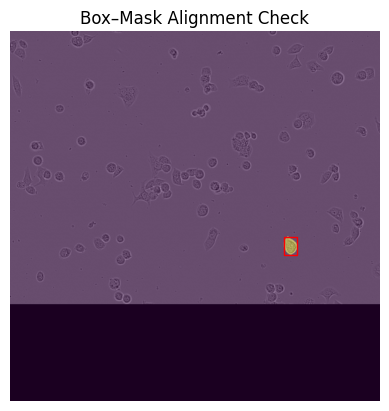

In [14]:
import matplotlib.pyplot as plt

batch = dataset[0]
img = batch["image"].permute(1,2,0).cpu()
mask = batch["mask"][0].cpu()
box = batch["box"][0].cpu()

plt.imshow(img)
plt.imshow(mask, alpha=0.4)

x0,y0,x1,y1 = box
plt.gca().add_patch(
    plt.Rectangle((x0,y0), x1-x0, y1-y0, fill=False, color="red")
)

plt.title("Box–Mask Alignment Check")
plt.axis("off")
plt.show()

In [22]:
def iou_loss(logits, targets, eps=1e-6):
    """
    logits: [B,1,H,W] raw SAM outputs
    targets: [B,1,H,W] binary {0,1}
    """
    probs = torch.sigmoid(logits)

    intersection = (probs * targets).sum(dim=(2, 3))
    union = probs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)) - intersection

    iou = (intersection + eps) / (union + eps)
    loss = 1 - iou

    return loss.mean()

In [23]:
from torch.utils.data import DataLoader
from tqdm import tqdm


# freeze everything except mask decoder
for p in sam.image_encoder.parameters():
    p.requires_grad = False
for p in sam.prompt_encoder.parameters():
    p.requires_grad = False

optimizer = torch.optim.AdamW(
    sam.mask_decoder.parameters(), lr=1e-5
)

loader = DataLoader(dataset, batch_size=1, shuffle=True) # very useful not just for convenience

In [30]:
sam.train()

for step, batch in enumerate(loader):
    img = batch["image"].to(device)      # [B,3,1024,1024]
    gt_mask = batch["mask"].to(device)   # [B,1,1024,1024]
    box = batch["box"].to(device)        # [B,1,4]

    with torch.no_grad():
        image_embedding = sam.image_encoder(img)

    sparse, dense = sam.prompt_encoder(
        points=None,
        boxes=box,
        masks=None
    )

    low_res_masks, _ = sam.mask_decoder(
        image_embedding,
        image_pe=sam.prompt_encoder.get_dense_pe().to(device),
        sparse_prompt_embeddings=sparse,
        dense_prompt_embeddings=dense,
        multimask_output=False
    )

    # upsample prediction
    pred_mask = torch.nn.functional.interpolate(
        low_res_masks,
        size=(1024,1024),
        mode="bilinear",
        align_corners=False
    )

    loss = iou_loss(pred_mask, gt_mask)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if step % 100 == 0:
        print(f"step {step}, loss {loss.item():.4f}")
    



step 0, loss 0.2667
step 100, loss 0.1299
step 200, loss 0.2648
step 300, loss 0.3553
step 400, loss 0.1360
step 500, loss 0.2643
step 600, loss 0.3375
step 700, loss 0.1761
step 800, loss 0.3333
step 900, loss 0.1294
step 1000, loss 0.1947
step 1100, loss 0.4878
step 1200, loss 0.3136
step 1300, loss 0.3117
step 1400, loss 0.1761
step 1500, loss 0.3897
step 1600, loss 0.1544
step 1700, loss 0.1937
step 1800, loss 0.1022
step 1900, loss 0.4823
step 2000, loss 0.2050
step 2100, loss 0.2267
step 2200, loss 0.2991
step 2300, loss 0.1844
step 2400, loss 0.2105
step 2500, loss 0.2331
step 2600, loss 0.1250
step 2700, loss 0.5152
step 2800, loss 0.1689
step 2900, loss 0.1173
step 3000, loss 0.0766
step 3100, loss 0.1163
step 3200, loss 0.2037


In [31]:
# why 256 x 256? because Image encoder outputs features at 1/16 resolution
# yet the output is just logits for cross entropy convenience we need to look at prob
mask_prob = torch.sigmoid(low_res_masks)
print(mask_prob)

tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 2.0969e-37, 0.0000e+00,  ..., 1.3405e-35,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.3764e-37,
           4.2654e-34, 0.0000e+00],
          [0.0000e+00, 9.8673e-34, 0.0000e+00,  ..., 4.6557e-34,
           0.0000e+00, 0.0000e+00],
          [1.9942e-38, 4.0246e-36, 3.5837e-35,  ..., 1.0364e-34,
           1.2091e-33, 0.0000e+00]]]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


In [32]:
import torch.nn.functional as F

# low_res_masks: [B, 1, 256, 256]
pred_logits = low_res_masks

# probability mask
pred_prob = torch.sigmoid(pred_logits)

# upsample to image size (1024x1024)
pred_prob_up = F.interpolate(
    pred_prob,
    size=(1024, 1024),
    mode="bilinear",
    align_corners=False
)

# binary mask (for evaluation / overlay)
pred_mask = (pred_prob_up > 0.5).float()


In [33]:
import numpy as np

# image: [B,3,1024,1024]
img_np = img[0].detach().cpu().permute(1, 2, 0).numpy()

# gt_mask: [B,1,1024,1024]
gt_mask_np = gt_mask[0, 0].detach().cpu().numpy()

# pred mask
pred_mask_np = pred_mask[0, 0].detach().cpu().numpy()
pred_prob_np = pred_prob_up[0, 0].detach().cpu().numpy()


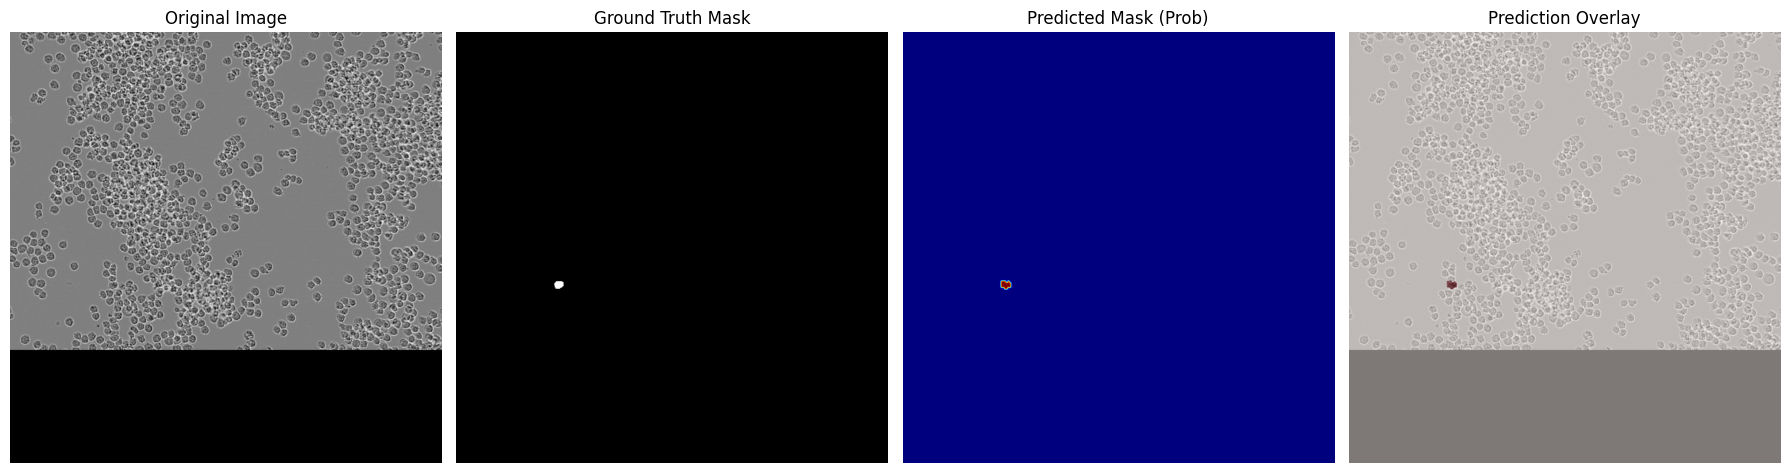

In [34]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(18, 5))

# original image
axs[0].imshow(img_np)
axs[0].set_title("Original Image")
axs[0].axis("off")

# ground truth mask
axs[1].imshow(gt_mask_np, cmap="gray")
axs[1].set_title("Ground Truth Mask")
axs[1].axis("off")

# predicted probability heatmap
axs[2].imshow(pred_prob_np, cmap="jet")
axs[2].set_title("Predicted Mask (Prob)")
axs[2].axis("off")

# overlay prediction on image
axs[3].imshow(img_np)
axs[3].imshow(pred_mask_np, alpha=0.5, cmap="Reds")
axs[3].set_title("Prediction Overlay")
axs[3].axis("off")

plt.tight_layout()
plt.show()


In [35]:
# flatten for safety
pred_flat = pred_mask.view(-1)
gt_flat = gt_mask.view(-1)

intersection = (pred_flat * gt_flat).sum()
union = pred_flat.sum() + gt_flat.sum() - intersection

iou = intersection / (union + 1e-6)
dice = 2 * intersection / (pred_flat.sum() + gt_flat.sum() + 1e-6)

print(f"IoU  : {iou.item():.4f}")
print(f"Dice : {dice.item():.4f}")


IoU  : 0.7692
Dice : 0.8696


In [36]:
import os, json, time
import torch

def save_sam_registry(
    sam,
    optimizer,
    save_root="model_registry",
    model_name="livecell_sam_vit_b_boxprompt",
    metrics=None,
    config=None
):
    """
    Saves a registry-style artifact:
      model_registry/<model_name>/<version>/
        - mask_decoder.pt
        - optimizer.pt
        - metadata.json
    """
    os.makedirs(save_root, exist_ok=True)

    version = time.strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(save_root, model_name, version)
    os.makedirs(run_dir, exist_ok=True)

    # core weights (decoder-only fine-tune)
    torch.save(sam.mask_decoder.state_dict(), os.path.join(run_dir, "mask_decoder.pt"))

    # optional optimizer state
    if optimizer is not None:
        torch.save(optimizer.state_dict(), os.path.join(run_dir, "optimizer.pt"))

    metadata = {
        "model_name": model_name,
        "version": version,
        "created_at": version,
        "metrics": metrics or {},
        "config": config or {},
        "notes": "SAM fine-tune: trained mask_decoder only; encoders frozen.",
    }

    with open(os.path.join(run_dir, "metadata.json"), "w") as f:
        json.dump(metadata, f, indent=2)

    print("Saved to:", run_dir)
    return run_dir

In [37]:
run_dir = save_sam_registry(
    sam=sam,
    optimizer=optimizer,
    metrics={"val_iou": 0.87},
    config={
        "prompt": "box",
        "backbone": "vit_b",
        "image_size": 1024,
        "loss": "IoU (sigmoid)",
        "lr": 1e-5,
    }
)

Saved to: model_registry\livecell_sam_vit_b_boxprompt\20260123_220829


In [38]:
import json, os
import torch

def load_sam_registry(sam, run_dir, device="cuda"):
    # load weights into mask decoder
    state = torch.load(os.path.join(run_dir, "mask_decoder.pt"), map_location="cpu")
    sam.mask_decoder.load_state_dict(state)
    sam.to(device)
    sam.eval()

    meta_path = os.path.join(run_dir, "metadata.json")
    metadata = None
    if os.path.exists(meta_path):
        with open(meta_path, "r") as f:
            metadata = json.load(f)

    return sam, metadata

# Example:
sam, metadata = load_sam_registry(sam, run_dir=run_dir, device=device)
print(metadata)

{'model_name': 'livecell_sam_vit_b_boxprompt', 'version': '20260123_220829', 'created_at': '20260123_220829', 'metrics': {'val_iou': 0.87}, 'config': {'prompt': 'box', 'backbone': 'vit_b', 'image_size': 1024, 'loss': 'IoU (sigmoid)', 'lr': 1e-05}, 'notes': 'SAM fine-tune: trained mask_decoder only; encoders frozen.'}


The following content is about understanding SAM

In [13]:
import torch

def measure(fn, *args, **kwargs):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    torch.cuda.synchronize()
    start.record()
    out = fn(*args, **kwargs)
    end.record()
    torch.cuda.synchronize()

    return out, start.elapsed_time(end)  # milliseconds


In [18]:
sam.train()

encoder_times = []
decoder_times = []

for step, batch in enumerate(loader):
    optimizer.zero_grad(set_to_none=True)

    # ---- load batch ----
    img = batch["image"].to(device)      # [B,3,1024,1024]
    gt_mask = batch["mask"].to(device)   # [B,1,1024,1024]
    box = batch["box"].to(device)        # [B,1,4]

    # ---- normalize image ----
    img = (img - sam.pixel_mean) / sam.pixel_std

    # ---- image encoder (timed, frozen) ----
    with torch.no_grad():
        image_embedding, t_enc = measure(
            sam.image_encoder,
            img
        )

    # ---- prompt encoder (cheap, no timing needed) ----
    sparse, dense = sam.prompt_encoder(
        points=None,
        boxes=box,
        masks=None
    )

    # ---- mask decoder (timed, trainable) ----
    (low_res_masks, _), t_dec = measure(
        sam.mask_decoder,
        image_embedding,
        sam.prompt_encoder.get_dense_pe().to(device),
        sparse,
        dense,
        False
    )

    # ---- upsample prediction ----
    pred_mask = torch.nn.functional.interpolate(
        low_res_masks,
        size=(1024, 1024),
        mode="bilinear",
        align_corners=False
    )

    # ---- loss ----
    loss = iou_loss(pred_mask, gt_mask)

    # ---- backward ----
    loss.backward()
    optimizer.step()

    # ---- record timings ----
    encoder_times.append(t_enc)
    decoder_times.append(t_dec)

    # ---- logging ----
    if step % 100 == 0:
        print(
            f"step {step:05d} | "
            f"loss {loss.item():.4f} | "
            f"enc {t_enc:.1f} ms | "
            f"dec {t_dec:.1f} ms"
        )
    break

step 00000 | loss 0.8821 | enc 286.9 ms | dec 3.4 ms
